In [2]:
# Dependancies
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import time
import pandas as pd
from scipy import stats

c:\Users\billo\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\billo\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\billo\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Define the model

In our implementations, 
- $n$ is the number of observations $y = (y_1, ..., y_n)$. $y_i | \theta_i \sim F(\theta) = N(\theta, \tau)$ where $\tau$ is fixed. The prior on the $\theta_i$ is of the form $G_0 = N(0,1)$. 
- $c = (c_1, ..., c_n)$ is a list of integers, where $c_i$ is the cluster of observation $i$
- $\phi$ or $\theta$ depending of the algorithms is a list where $\phi_i$ is the mean of the cluster $c_i$


We initialize with each observation belonging to one cluster with mean equal to the value of the observation except for algorithm 4 and 5 where we initialize all observations in one cluster with $\theta$ equal to the empirical mean of the observations


### Dataset

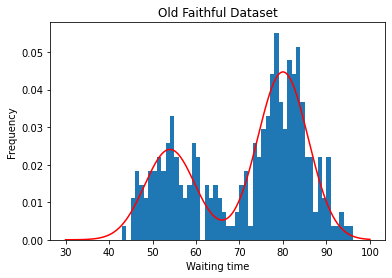

In [3]:
faithful_df = pd.read_csv("faithful.csv")
del faithful_df["Unnamed: 0"]
faithful_data = np.array(faithful_df["waiting"])

def prior_distribution(x, mean1=54, mean2=80, var=5.8, mixture=0.35):
    return mixture * stats.norm.pdf(x, mean1, var) + (1 - mixture) * stats.norm.pdf(x, mean2, var)

# Hand-picked parameters
x = np.linspace(30, 100, 1000)
plt.plot(x, prior_distribution(x), color='red')


# Plot the histogram of the old faithful dataset
plt.hist(faithful_data, bins=range(min(faithful_data), max(faithful_data) + 1), density=True)

plt.xlabel('Waiting time')
plt.ylabel('Frequency')
plt.title('Old Faithful Dataset')
plt.show()


###
faithful_data = faithful_data.astype(float)

This dataset contains the waiting time between the eruptions of the Old Faithful geyser in Yellowstone National Park, Wyoming, USA.
We observe that the observations seems to come from a mixture of two Gaussians. We will try to infer the means of each of those Gaussians as well which cluster each observation belongs to. Regarding the variance, we hand tested different parameters and $\tau = 5.8$ for both Gaussian seems to be a great fit. 

As we changed our data, we ajusted the following parameters :
- G_0 sampler
- G_0 logdensity
- F_likelihood


### General Case

In [4]:
tau = 5.8
alpha = 0.5

g0_mean = np.mean(faithful_data)
g0_std = np.std(faithful_data)

In [5]:
# G0 is a normal distribution
def g0_sampler():
    return np.random.normal(g0_mean, g0_std)

# f is a normal distribution with mean theta and variance tau
def f_sampler(theta):
    return np.random.normal(theta, tau)

# F(x, theta) evaluates F (normal distribution) in x
def F_likelihood(theta, x):
    return np.exp(-(theta - x)**2 / (2 * tau**2))

def F_loglikelihood(theta, x):
    return -(theta - x)**2 / (2 * tau**2)

In [6]:
def g0_logdensity(theta):
    return -(theta - g0_mean)**2 / (2 * g0_std**2) - np.log(np.sqrt(2 * np.pi) * g0_std)

Assume $x_i \mid \theta_i \sim \mathcal{N}\left(\theta_i, \tau^2\right)$ i.i.d.and $\theta \sim \mathcal{N}\left(\mu_0 = 0, \sigma^2 = 1\right)$. Then:
$$
\theta \mid x_{c1}, x_{c2}, \cdots, x_{|c|} \sim \mathcal{N}\left(\frac{\sigma^2}{\frac{\tau^2}{|c|}+\sigma^2} \overline{x_c}+\frac{\tau^2}{\frac{\tau^2}{|c|}+\sigma^2} \mu_0,\left(\frac{1}{\sigma^2}+\frac{|c|}{\tau^2}\right)^{-1}\right)
$$


$|c|$ is cardinal of class $c$

In [7]:
def posterior(y):
    mean = np.mean(y)
    number = len(y)
    return np.random.normal(mean/(1+ tau^2/number), 1/(1+ number/tau^2))

### Dirichlet process

In [8]:
def DP_loglikelihood(thetas):
    lh = 0
    for i, theta in enumerate(thetas):
        if theta in thetas[:i]:
            lh += np.log(np.sum(thetas[:i] == theta) / (i + alpha))
        else:
            lh += np.log(alpha / (i + alpha)) + g0_logdensity(theta)
    return lh

### Auxilary functions

In [9]:
def find_unused_cluster(c):
    # Find the first unused cluster
    for k in range(len(c)):
        if np.sum(c == k) == 0:
            return k

    raise Exception("No unused cluster found")

def update_cluster_phis(c, phi, lh, y):
    for c_unique in np.unique(c):
        phi[c_unique] = np.mean(y[c == c_unique])
        lh[c == c_unique] = F_loglikelihood(phi[c_unique], y[c == c_unique])


In [10]:
# Compute autocorrelation of a multivariate time series
def autocorr(x):
    ac = np.zeros_like(x)
    x_centered = x - np.mean(x, axis=0)
    for i in range(x.shape[1]):
        ac[:, i] = np.correlate(x_centered[:, i], x_centered[:, i], mode='full')[x.shape[0]-1:]
    return ac

#### Auxilary functions for the conjugate prior case (Algorithms 1, 2, 3)

In [11]:
def Hi_sampler(y):
    m = (y / tau**2) / (1 / tau**2 + 1 / 1**2)
    s = 1 / (1 / tau**2 + 1 / 1**2)
    return np.random.normal(m, s)

def ri_integral(y):
    return tau * np.exp(-y**2 / (2 + 2 * tau**2)) / np.sqrt(tau**2 + 1)

### Util functions to run Run algorithms

In [12]:
def to_cs_phis(thetas):
    phis = np.zeros_like(thetas, dtype=float)
    cs = np.zeros_like(thetas, dtype=int)
    for i, theta in enumerate(thetas):
        for c_unique, theta_unique in enumerate(np.unique(theta)):
            cs[i, theta == theta_unique] = c_unique
            phis[i, c_unique] = theta_unique
    return cs, phis

In [13]:
def run_algorithm(algorithm, N, y):
    """
    Run algorithm N times (n_iter) and plot evolution of log_likelyhood, theta and cluster assignments
    """
    # Run algorithm
    n = len(y)
    start_time =  time.time()
    cs, phis = algorithm(N, y)
    end_time = time.time()

    print(f"Time per interation: {(end_time - start_time) / N:.6f} seconds")

    complete_llhs = np.zeros((N+1), dtype=float)
    for i in range(N+1):
        complete_llhs[i] = F_loglikelihood(phis[i, cs[i]], y).sum() + DP_loglikelihood(phis[i, cs[i]])

    # Compute autocorrelation time of number of distinct clusters
    ks = np.zeros((N+1), dtype=int)
    for i in range(N+1):
        ks[i] = len(np.unique(cs[i]))

    ac = autocorr(ks.reshape(-1, 1))
    ac = ac / ac[0]
    # ac_time_limit is the first time the autocorrelation is below 0.05
    ac_time_limit = np.argmax(ac < 0.05)
    ac_time = 1 + 2 * np.sum(ac[:ac_time_limit])
    print(f"Autocorrelation time: {ac_time:.2f}")


    # define infinite list of colors
    COLORS = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for i, cluster in enumerate(np.unique(cs[-1])):
        if np.sum(cs[-1] == cluster) == 1:
            plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], color="black")
        else:
            color = next(COLORS)
            plt.scatter(np.arange(n)[cs[-1] == cluster], y[cs[-1] == cluster], label=i, color=color)
            plt.axhline(phis[-1, cluster], color=color, linestyle="--")
    plt.title("Generated data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    # Plot evolution of log likelihood
    plt.figure()
    plt.plot(np.arange(N+1), complete_llhs)
    plt.title("Log likelihood")
    plt.xlabel("Iteration")
    plt.ylabel("Log likelihood")
    plt.show()

    # plot evolution of theta
    plt.figure()
    it_list = []
    phi_list = []
    size_list = []
    for it in range(0, N+1):
        phis_counts = np.unique(phis[it, cs[it]], return_counts=True)
        phi_list.extend(phis_counts[0])
        it_list.extend([it] * len(phis_counts[0]))
        size_list.extend(phis_counts[1])

    plt.scatter(it_list, phi_list, s= 100 * np.square(np.array(size_list, dtype=float) / np.max(size_list)), c=size_list)
    plt.title("Cluster assignments")
    plt.xlabel("Iteration")
    plt.ylabel("Cluster mean")
    plt.colorbar()
    plt.show()


    plt.plot(ac)
    plt.title("Autocorrelation of number of clusters")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    # Plot ac_time_limit
    plt.axvline(ac_time_limit, color="red", linestyle="--")
    plt.show()


In [14]:
def run_algorithm_multiple(algorithm, N, R, y):
    """
    Run algorithm N times (n_iter) and plot evolution of log_likelyhood, theta and cluster assignments
    """
    # Run algorithm
    n = len(y)
    cs_list = []
    phis_list = []
    y_list = [y for _ in range(R)]
    start_time =  time.time()
    for y in y_list:
        cs, phis = algorithm(N, y)
        cs_list.append(cs)
        phis_list.append(phis)
    end_time = time.time()

    print(f"Total time: {(end_time - start_time):.6f} seconds")
    print(f"Time per interation: {(end_time - start_time) / (R*N):.6f} seconds")

    complete_llhs = np.zeros((R, N+1), dtype=float)
    for r in range(R):
        for i in range(N+1):
            complete_llhs[r, i] = F_loglikelihood(phis_list[r][i, cs_list[r][i]], y_list[r]).sum() + DP_loglikelihood(phis_list[r][i, cs_list[r][i]])

    # ------------------------------ #
    # Final log likelihood and best log likelihood

    final_llhs = [llh[-1] for llh in complete_llhs]
    best_llhs = [np.max(llh) for llh in complete_llhs]

    print(f"Final log likelihood : mean : {np.mean(final_llhs):.2f}, std : {np.std(final_llhs):.2f}")
    print(f"Best log likelihood : mean : {np.mean(best_llhs):.2f}, std : {np.std(best_llhs):.2f}")


    # ------------------------------ #
    # Autocorrelation time - number of clusters

    # Compute autocorrelation time of number of distinct clusters
    ks = np.zeros((R, N+1), dtype=int)
    for r in range(R):
        for i in range(N+1):
            ks[r, i] = len(np.unique(cs_list[r][i]))

    ac = autocorr(ks.T) 
    print(ac.shape)
    ac = ac / ac[0]
    # ac_time_limit is the first time the autocorrelation is below 0.05
    ac_time_limit = np.argmax(ac < 0.05, axis=0)
    ac_times = []
    for r in range(R):
        ac_times.append(1 + 2 * np.sum(ac[1:ac_time_limit[r], r]))
    print(f"ACT n clusters : mean : {np.mean(ac_times):.2f}, std : {np.std(ac_times):.2f}")

    # ------------------------------ #
    # Autocorrelation time - phi[c]

    ac = autocorr(np.concatenate([np.array([
        phis_list[r][i, cs_list[r][i]]
        for i in range(N+1)
    ]).T for r in range(R)]).T)
    print(ac.shape)
    ac = ac / ac[0]
    # ac_time_limit is the first time the autocorrelation is below 0.05
    ac_time_limit = np.argmax(ac < 0.05, axis=0)
    ac_times = []
    for r in range(R):
        ac_time_avg = []
        for i in range(n):
            ac_time_avg.append(1 + 2 * np.sum(ac[1:ac_time_limit[r*n + i], r*n + i]))
        ac_times.append(np.mean(ac_time_avg))

    print(f"ACT thetas : mean : {np.mean(ac_times):.2f}, std : {np.std(ac_times):.2f}")

    # ------------------------------ #
    # Clusters

    print([np.unique(phi) for phi in phis_list ])

    

    print("-----------------------------")


## Algorithm 5

In [15]:
def algorithm_5_sampler(alpha, c_unique, c_count, c, n):
        # Draw a candidate phi_i_star from Eq 5.4
        new_parameter_prob = alpha / (n - 1 + alpha)
        old_parameter_prob = 1 / (n - 1 + alpha)
        # Sampling probabilities for all [old params , new param] and normalize to get a probability distribution
        sampling_prob = np.append(old_parameter_prob * c_count , new_parameter_prob)
        sampling_prob /= np.sum(sampling_prob)
        # Choose cluster with probability sampling_prob
        # The new cluster replaces an unused cluster
        ci_star = np.random.choice(np.append(c_unique, find_unused_cluster(c)), p=sampling_prob)
        return ci_star

def algorithm_5(n_iters, y, alpha):
    n = len(y)
    cs = np.zeros((n_iters+1, n), dtype=int)
    phis = np.zeros((n_iters+1, n), dtype=float)
    lhs = np.zeros((n_iters+1, n), dtype=float)
    # Initialization exception : all points are in the same cluster of mean = empirical_mean(y)
    phis[0] = np.full(n,np.mean(y))


    for iter in range(1,n_iters+1):
        c = cs[iter-1].copy()
        phi = phis[iter-1].copy()
        lh = lhs[iter-1].copy()

        for ii in range(n):
            c_unique, c_count = np.unique(c, return_counts=True)
            # get n_-i,c
            c_count -= (c_unique == c[ii]).astype(int)
            # Sample a ci_star from Eq 5.4
            ci_star = algorithm_5_sampler(alpha, c_unique, c_count, c, n)

            # If the sampled index is the last one, we sample from G0
            if ci_star == len(c_unique):
                phi_proposal = g0_sampler()
            else: # Else we use an existing cluster
                phi_proposal = phi[ci_star]
            
            lh_proposal = F_likelihood(phi_proposal, y[ii])

            # Compute acceptance probability
            acceptance_prob = min(1, lh_proposal / lh[ii])

            # Accept or reject
            if np.random.rand() < acceptance_prob:
                c[ii] = ci_star
                phi[c[ii]] = phi_proposal
                lh[ii] = lh_proposal
        


        for c_unique in np.unique(c):
            phi[c_unique] = np.mean(y[c == c_unique])

        cs[iter] = c.copy()
        phis[iter] = phi.copy()
        lhs[iter] = lh.copy()

    return cs, phis

C:\Users\billo\AppData\Local\Temp\ipykernel_14668\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.038610 seconds
Autocorrelation time: 1.00


C:\Users\billo\AppData\Local\Temp\ipykernel_14668\4270353638.py:23: RuntimeWarning: invalid value encountered in divide
  ac = ac / ac[0]


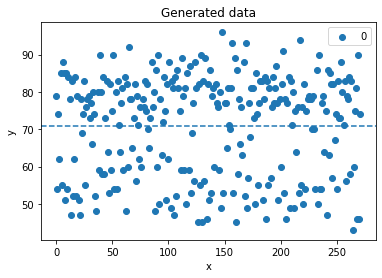

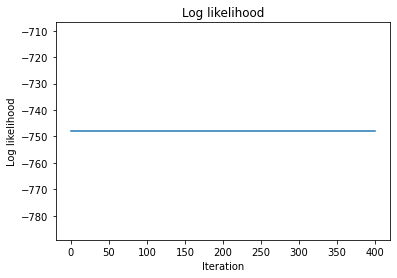

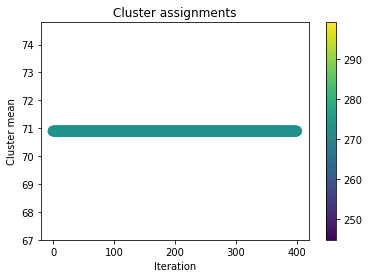

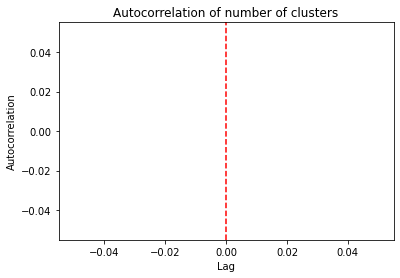

In [18]:
alpha = 0.001
run_algorithm(lambda N, y: algorithm_5(N, y, alpha), 400, faithful_data)

C:\Users\billo\AppData\Local\Temp\ipykernel_14668\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.036406 seconds
Autocorrelation time: 132.84


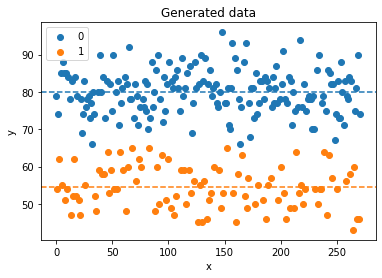

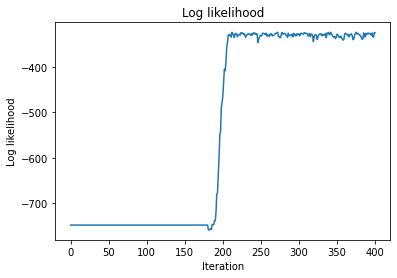

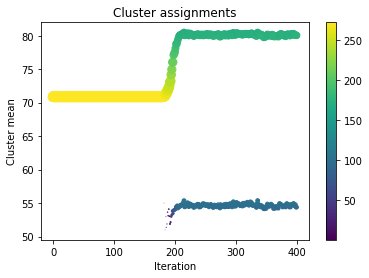

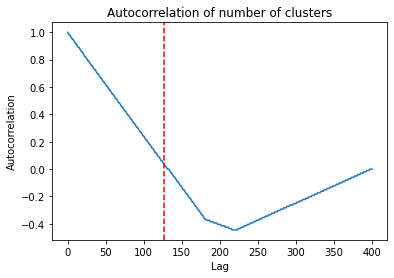

In [17]:
alpha = 0.01
run_algorithm(lambda N, y: algorithm_5(N, y, alpha), 400, faithful_data)

C:\Users\billo\AppData\Local\Temp\ipykernel_14668\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.039038 seconds
Autocorrelation time: 17.09


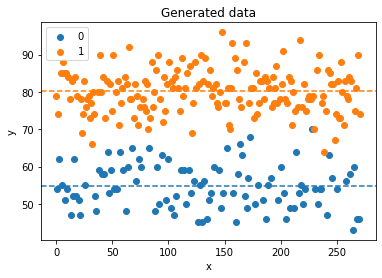

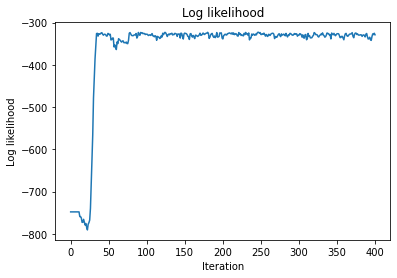

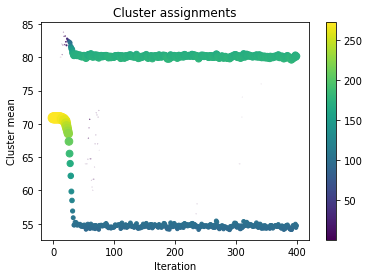

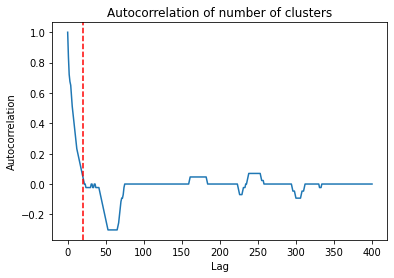

In [16]:
alpha = 0.05
run_algorithm(lambda N, y: algorithm_5(N, y, alpha), 400, faithful_data)

### Choosing Alpha

In [46]:
alphas = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.6, 0.8, 1, 2]

alpha = 0.1


C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.040672 seconds
Autocorrelation time: 42.33


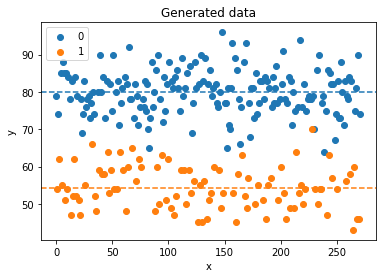

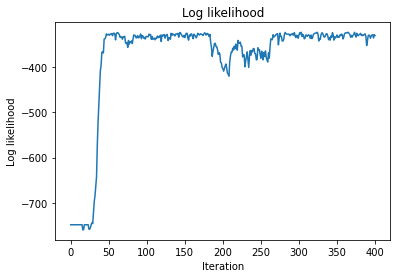

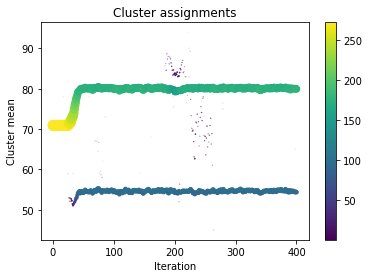

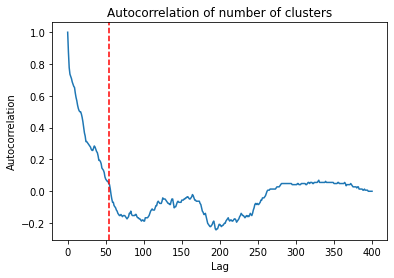

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.029507 seconds
Autocorrelation time: 44.60


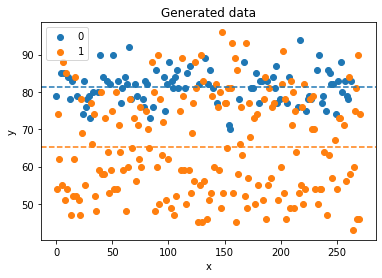

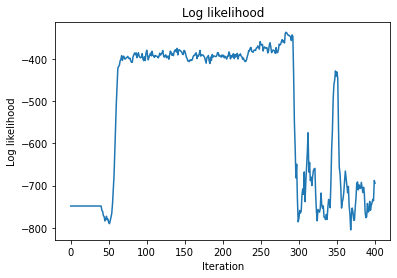

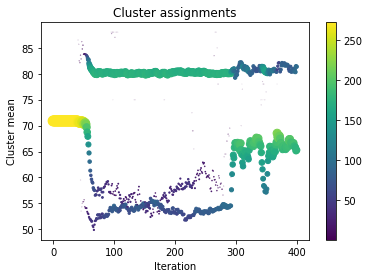

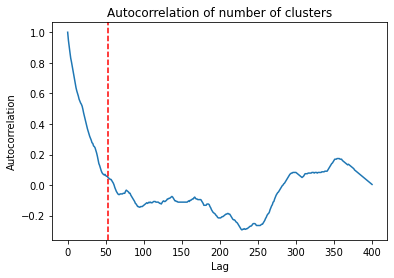

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.037202 seconds
Autocorrelation time: 41.63


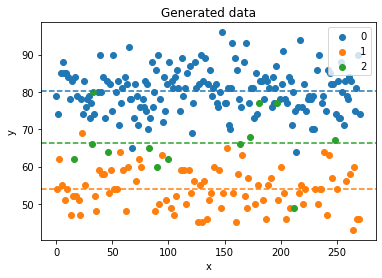

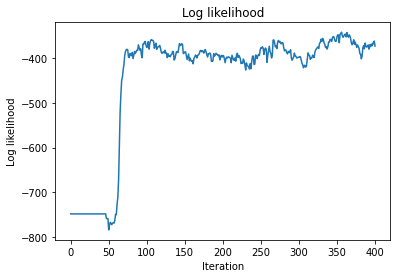

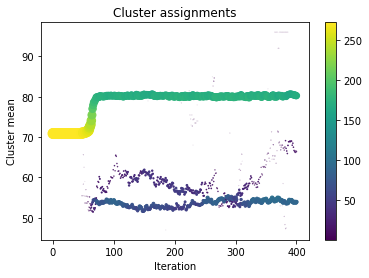

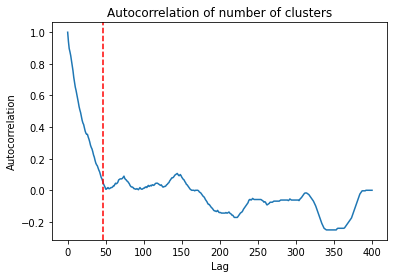

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.037663 seconds
Autocorrelation time: 77.75


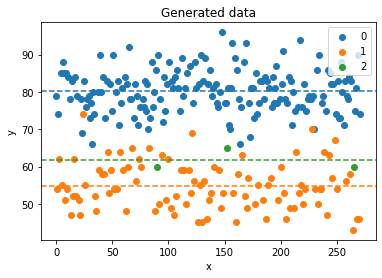

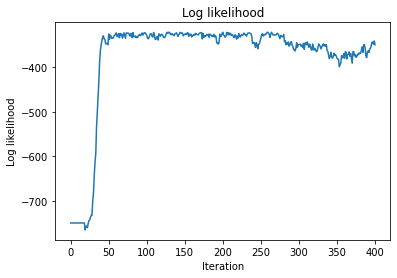

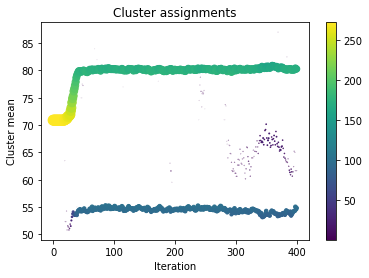

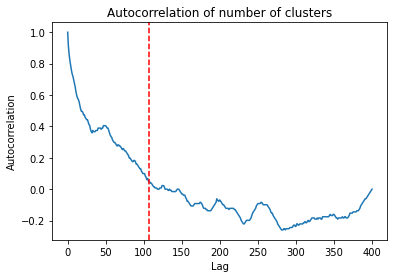

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.057227 seconds
Autocorrelation time: 25.41


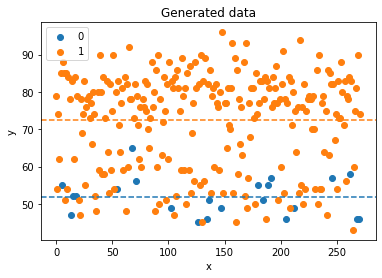

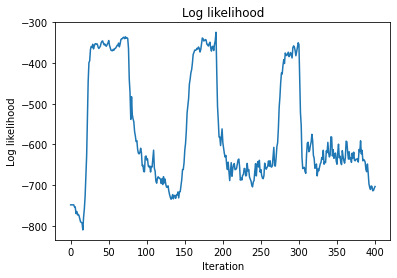

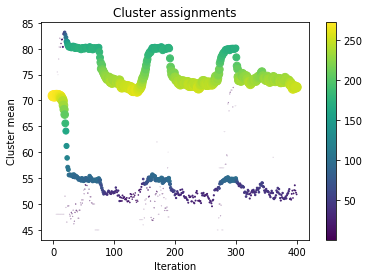

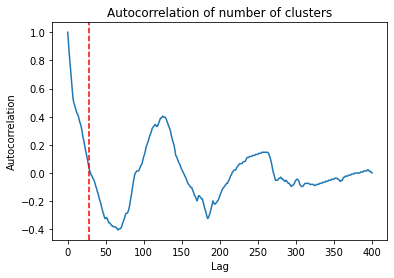

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.055125 seconds
Autocorrelation time: 33.58


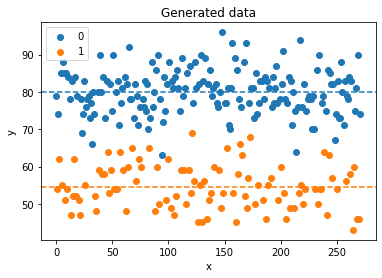

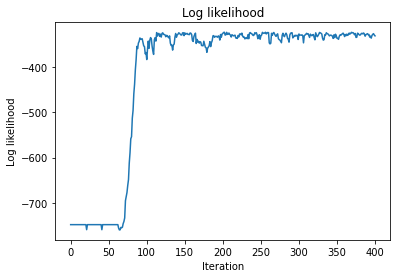

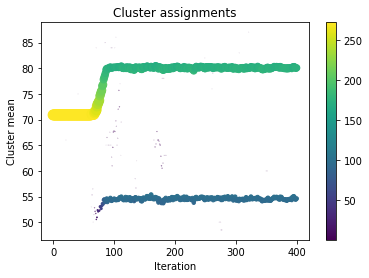

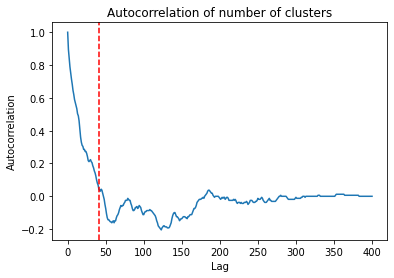

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.038619 seconds
Autocorrelation time: 34.15


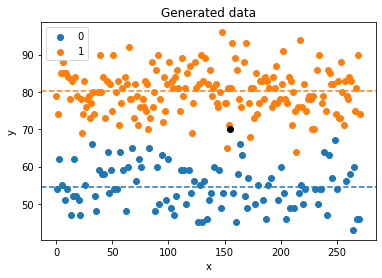

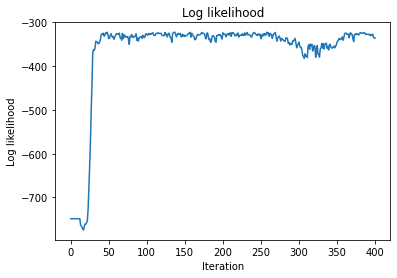

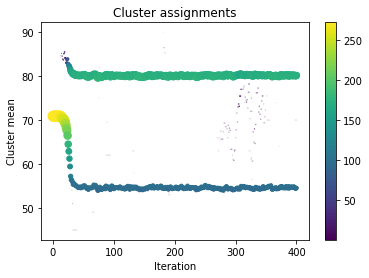

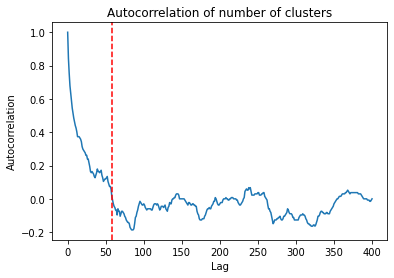

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.042675 seconds
Autocorrelation time: 25.98


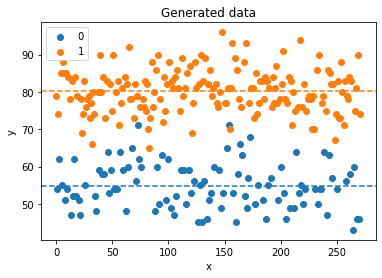

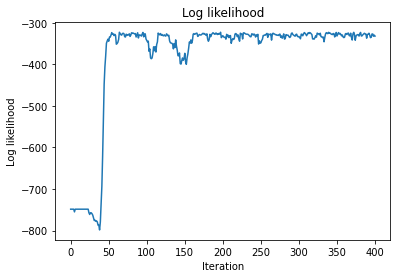

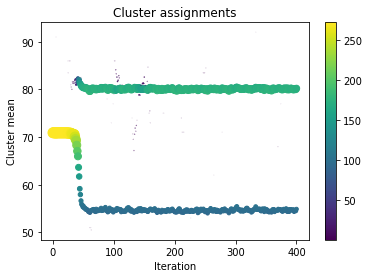

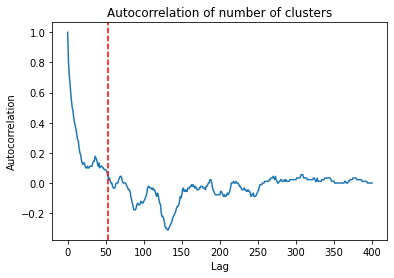

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.045478 seconds
Autocorrelation time: 40.30


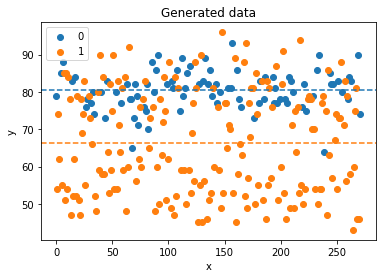

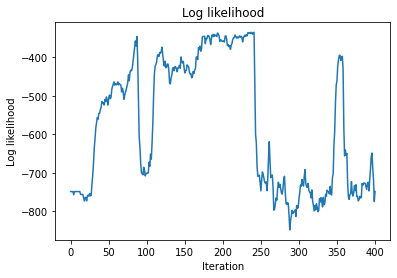

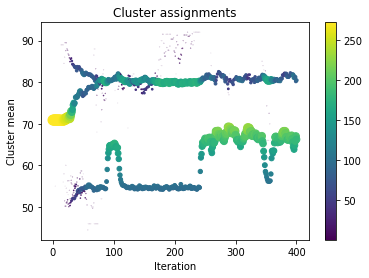

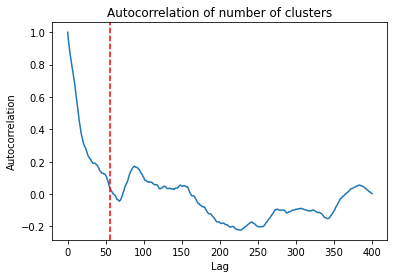

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.049020 seconds
Autocorrelation time: 65.40


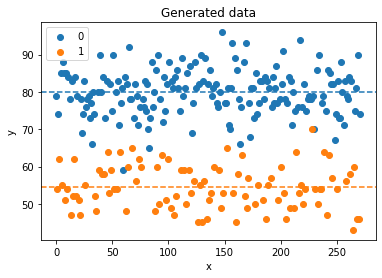

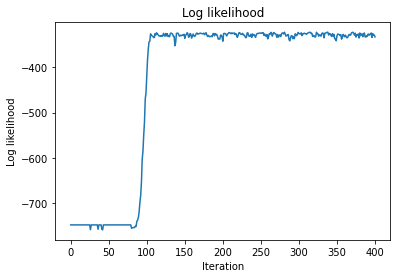

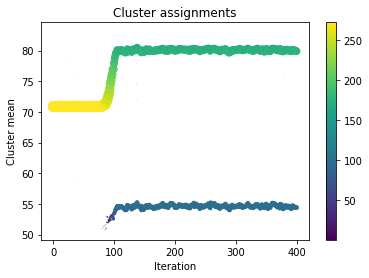

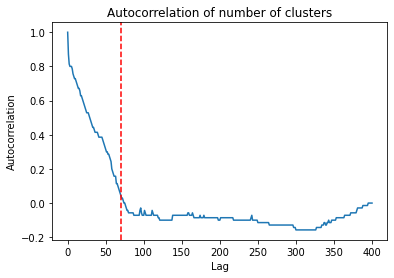

-----------------------------
alpha = 0.2


C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.039545 seconds
Autocorrelation time: 14.40


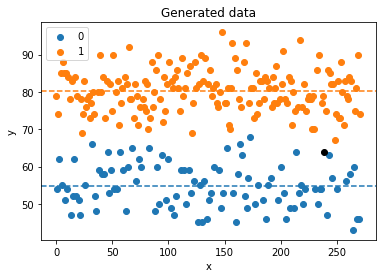

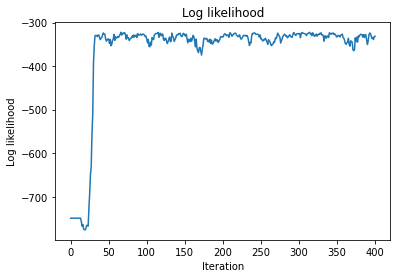

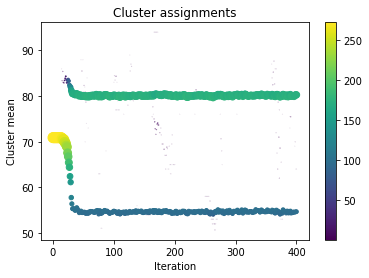

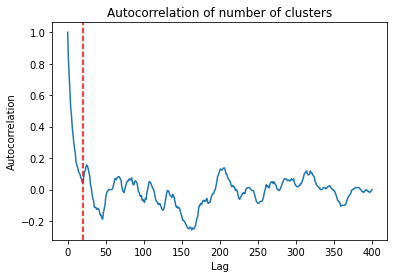

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.048796 seconds
Autocorrelation time: 38.44


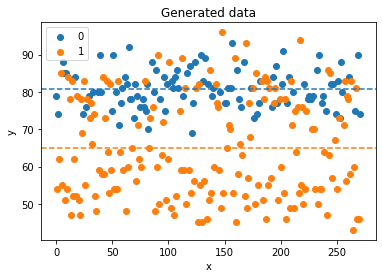

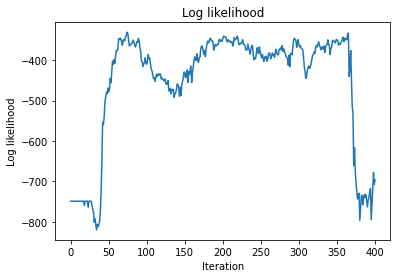

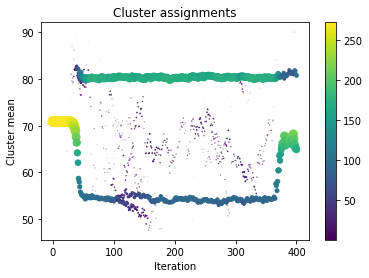

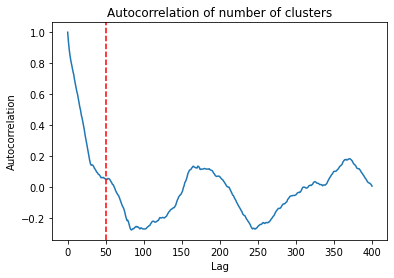

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.049050 seconds
Autocorrelation time: 40.52


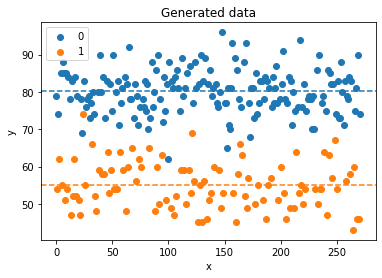

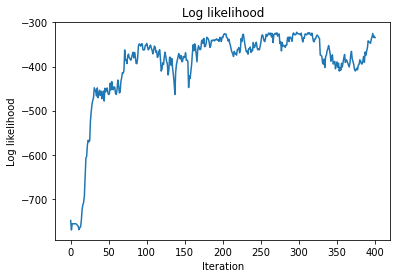

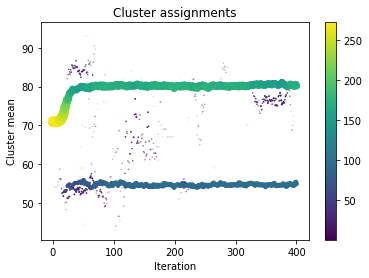

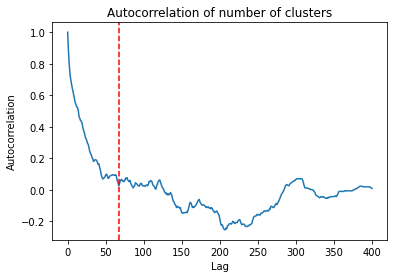

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.034252 seconds
Autocorrelation time: 26.72


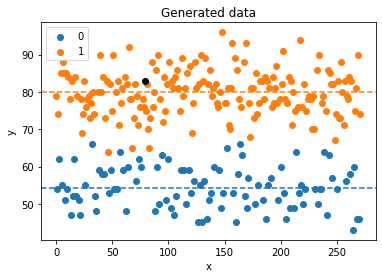

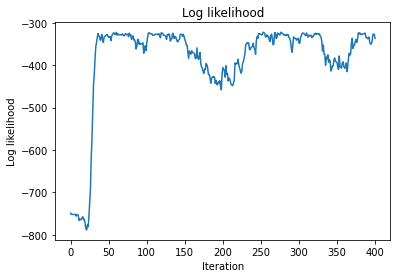

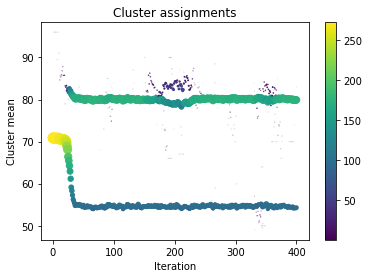

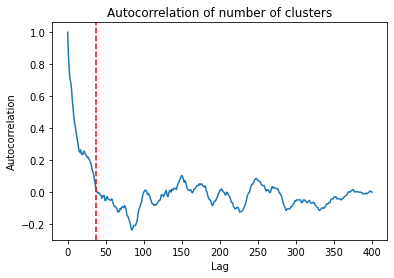

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.037056 seconds
Autocorrelation time: 80.21


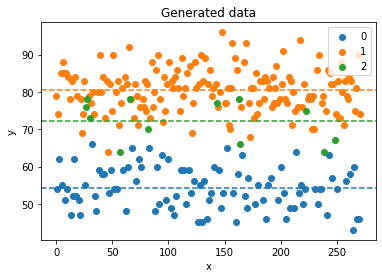

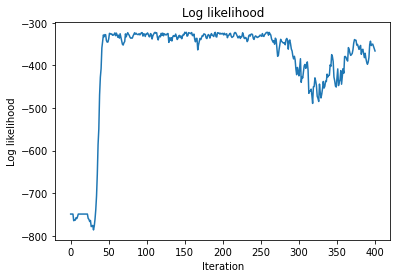

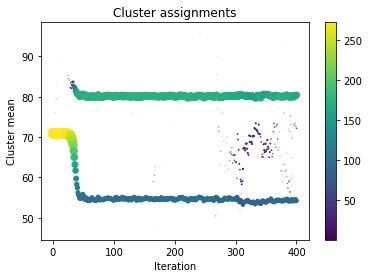

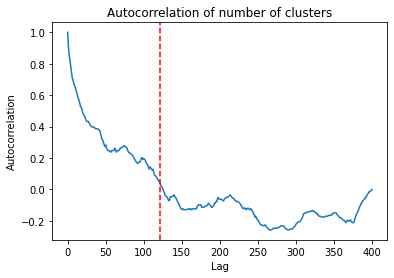

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.031015 seconds
Autocorrelation time: 25.84


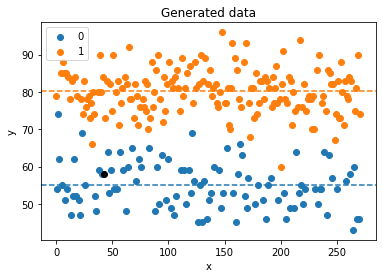

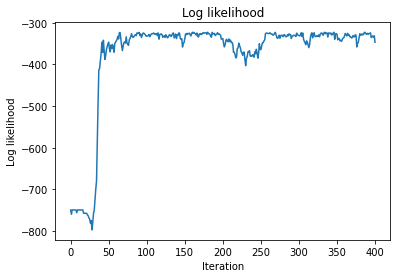

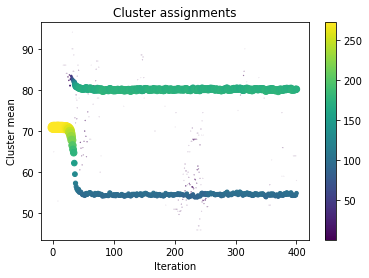

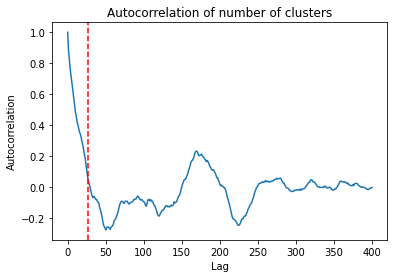

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.047048 seconds
Autocorrelation time: 21.75


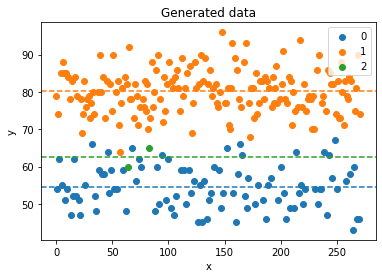

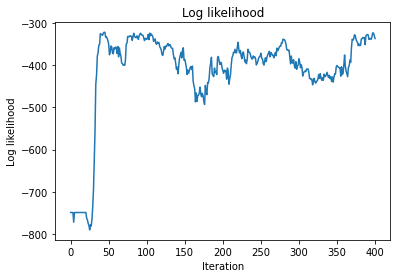

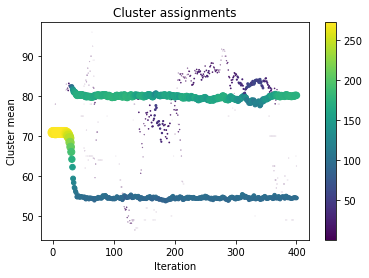

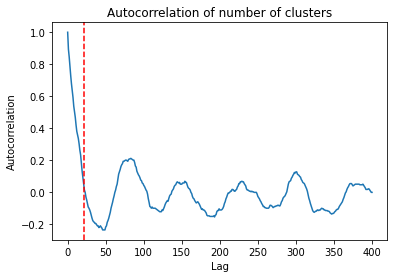

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.039029 seconds
Autocorrelation time: 27.41


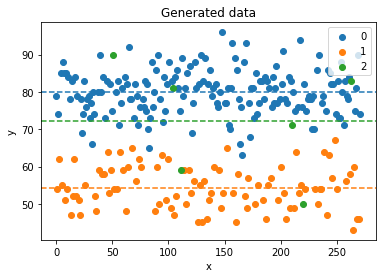

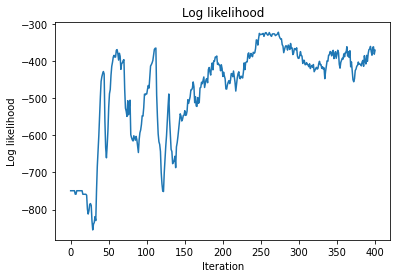

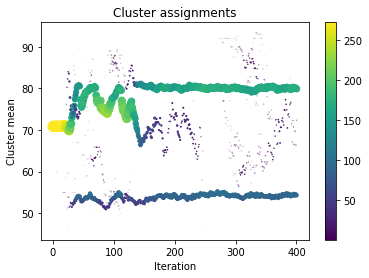

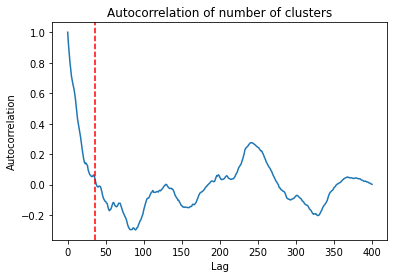

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.037007 seconds
Autocorrelation time: 36.25


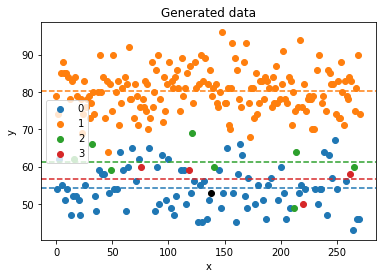

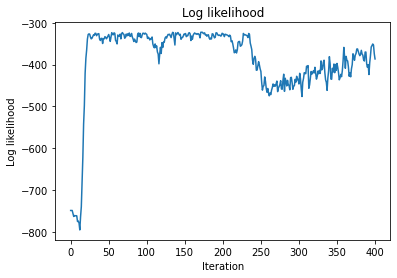

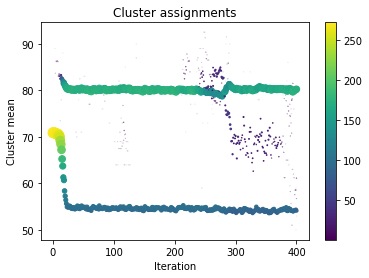

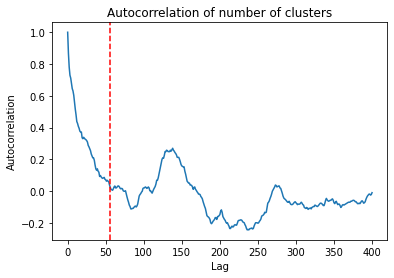

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.038779 seconds
Autocorrelation time: 37.07


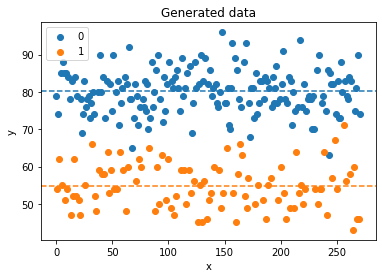

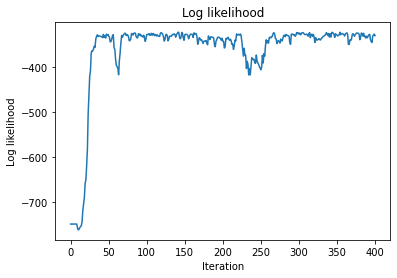

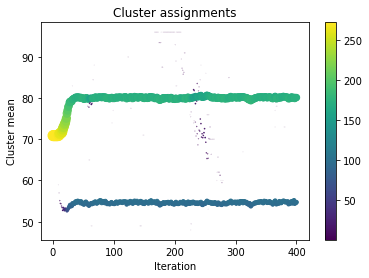

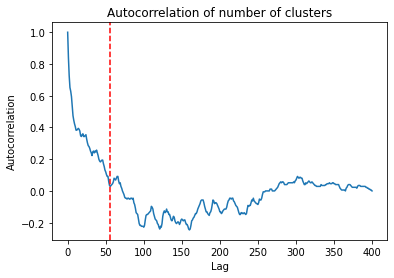

-----------------------------
alpha = 0.5


C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.037045 seconds
Autocorrelation time: 28.11


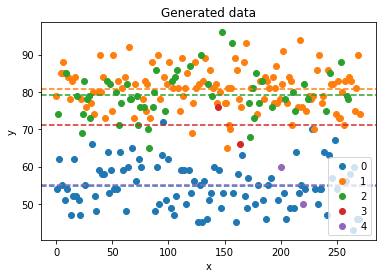

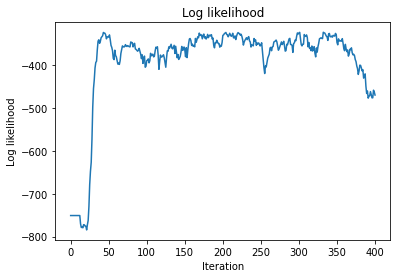

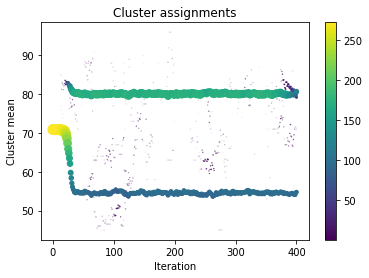

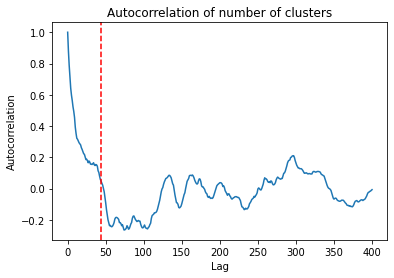

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.041415 seconds
Autocorrelation time: 23.51


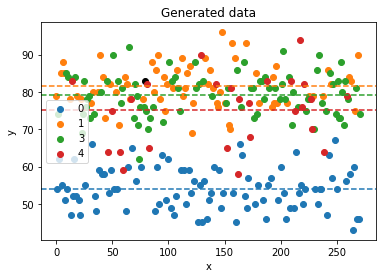

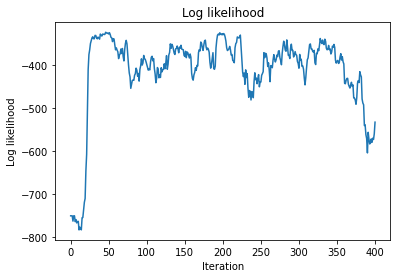

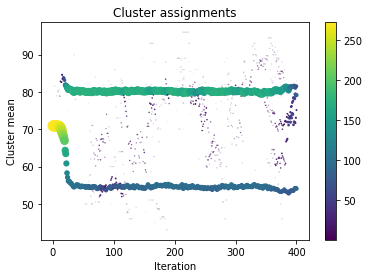

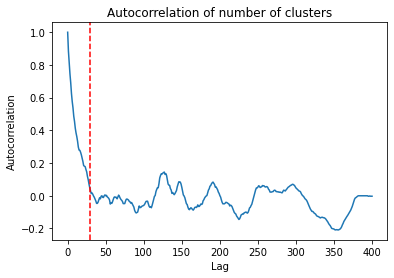

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.042314 seconds
Autocorrelation time: 19.16


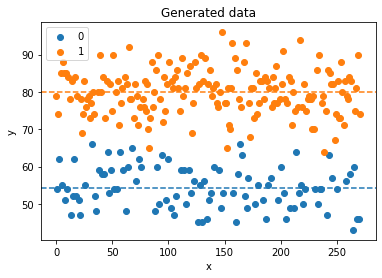

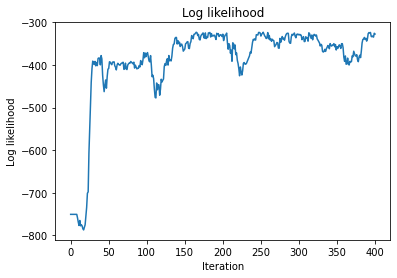

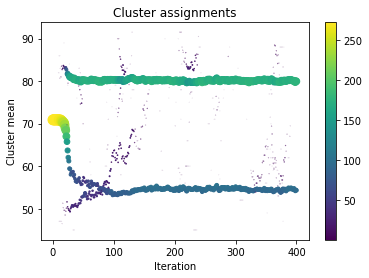

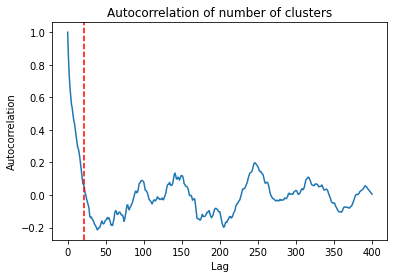

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.036304 seconds
Autocorrelation time: 58.94


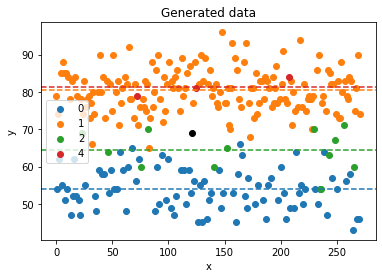

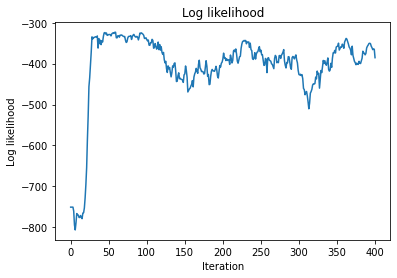

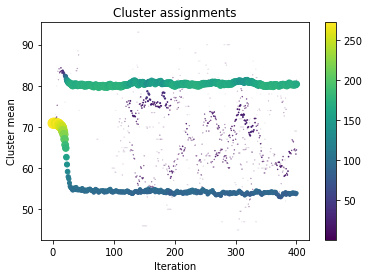

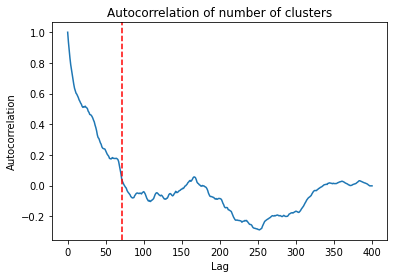

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.034170 seconds
Autocorrelation time: 28.54


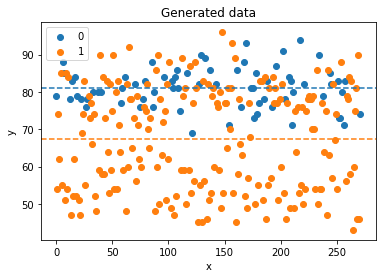

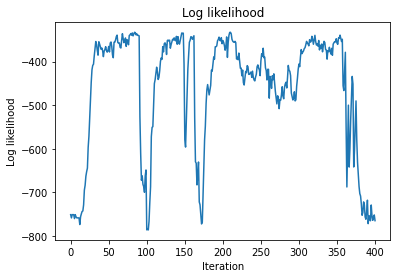

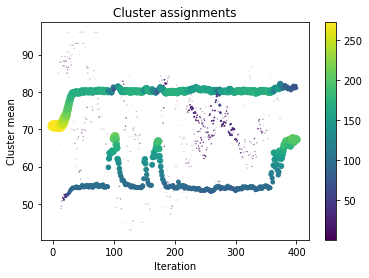

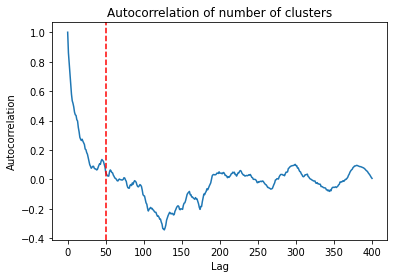

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.036580 seconds
Autocorrelation time: 36.99


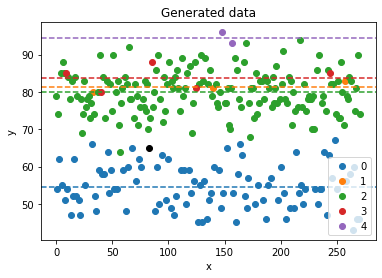

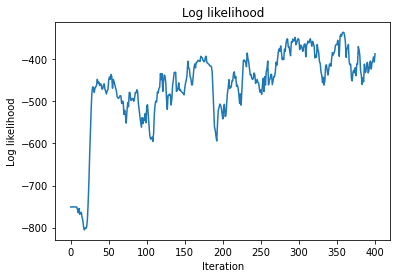

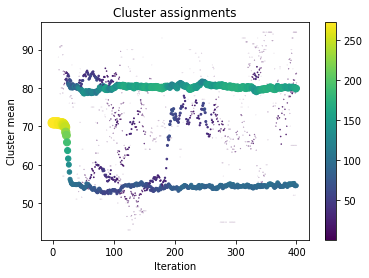

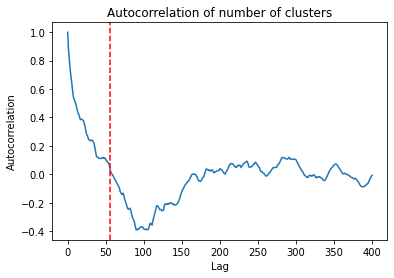

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.039870 seconds
Autocorrelation time: 25.29


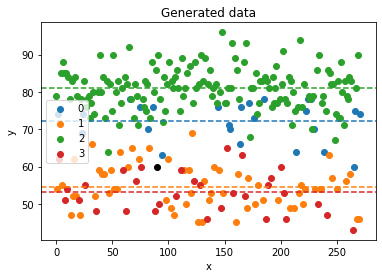

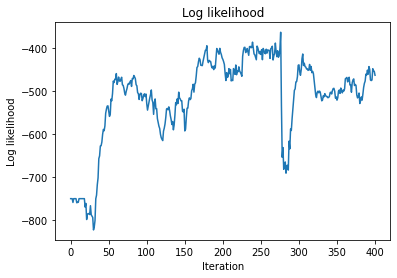

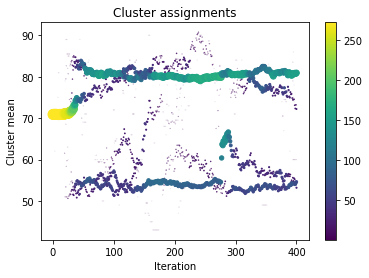

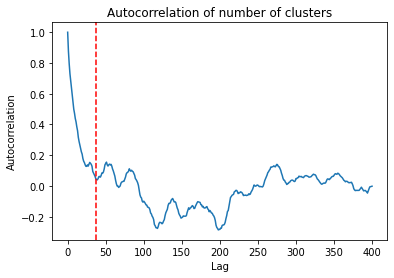

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.038858 seconds
Autocorrelation time: 17.53


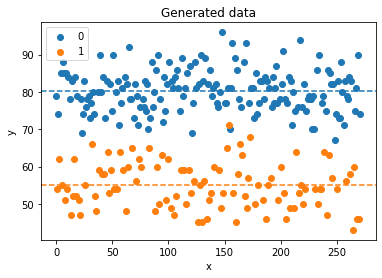

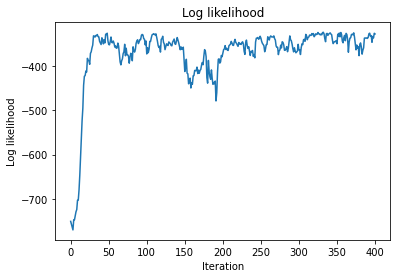

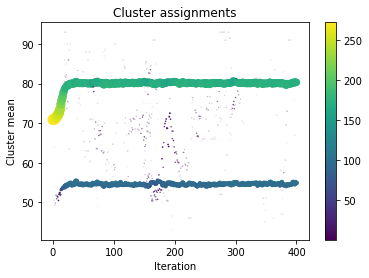

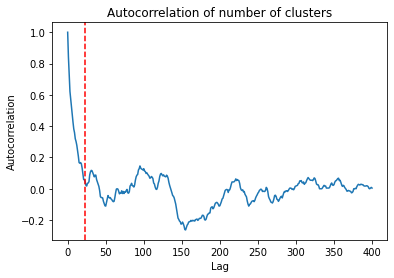

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.036229 seconds
Autocorrelation time: 42.40


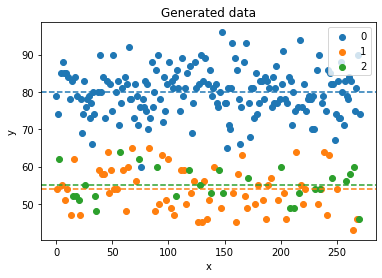

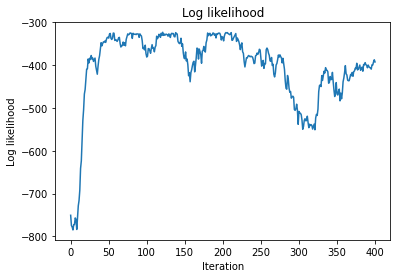

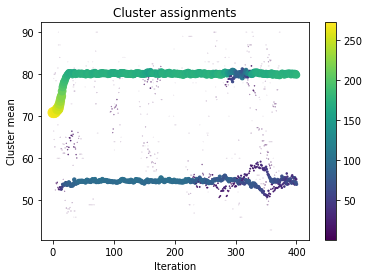

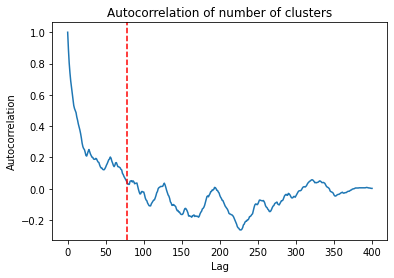

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.032230 seconds
Autocorrelation time: 10.32


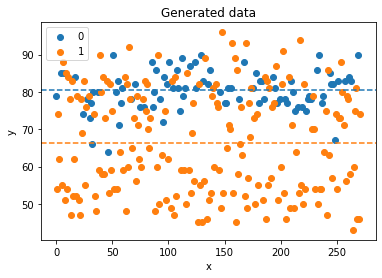

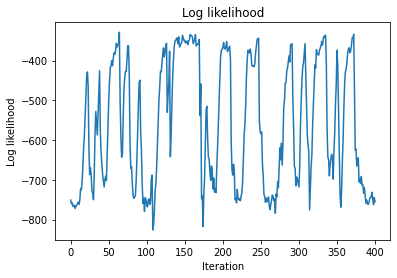

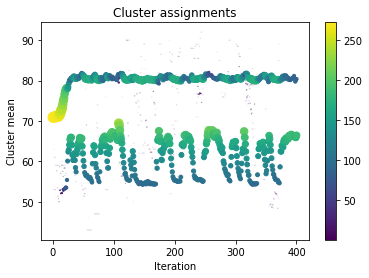

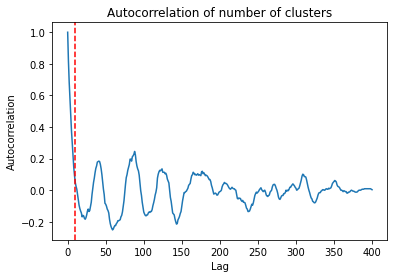

-----------------------------
alpha = 0.6


C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.037479 seconds
Autocorrelation time: 54.61


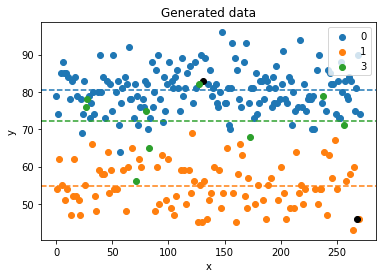

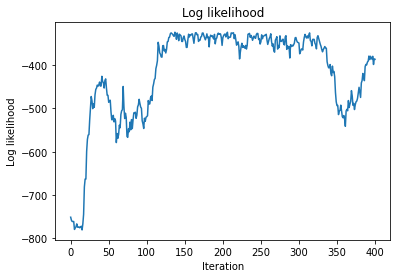

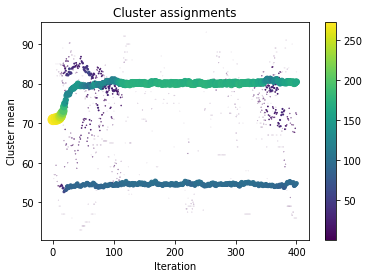

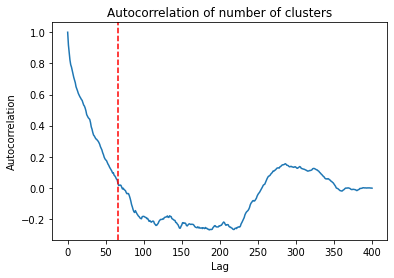

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.033539 seconds
Autocorrelation time: 11.74


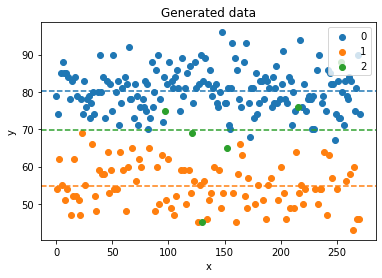

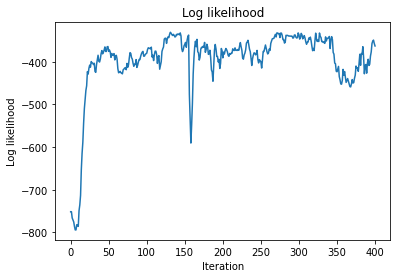

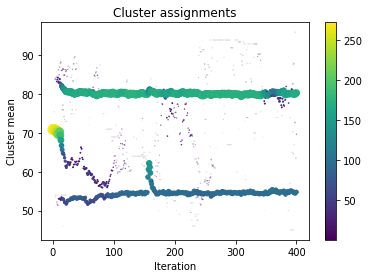

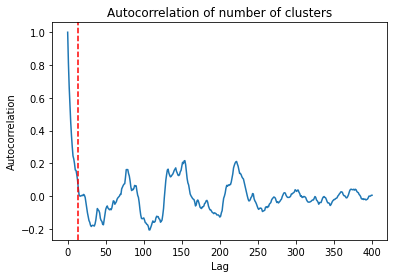

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.051035 seconds
Autocorrelation time: 16.93


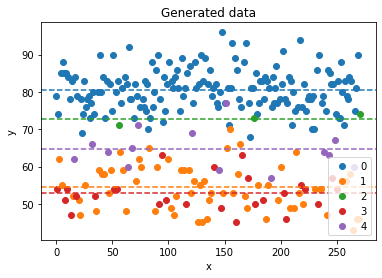

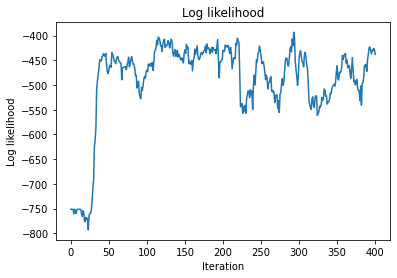

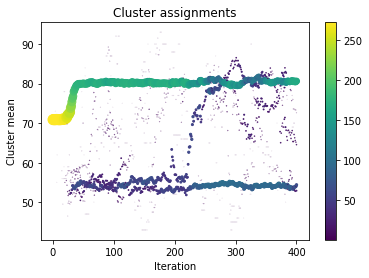

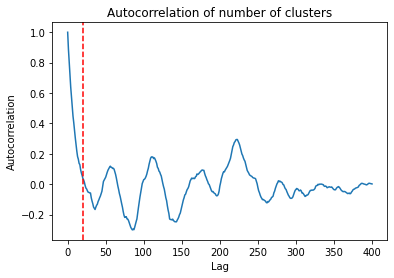

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.039774 seconds
Autocorrelation time: 27.04


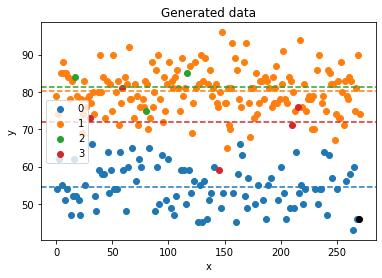

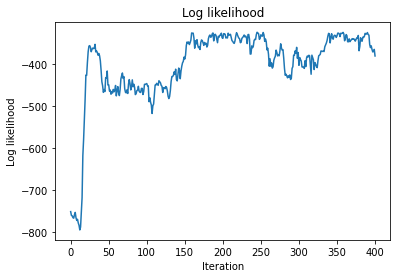

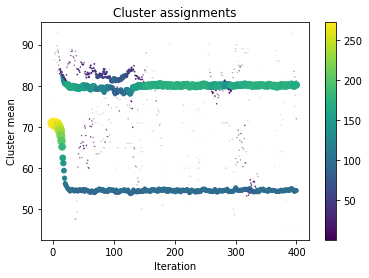

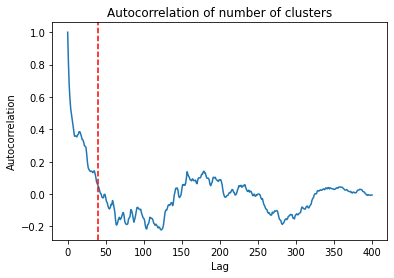

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.037236 seconds
Autocorrelation time: 21.43


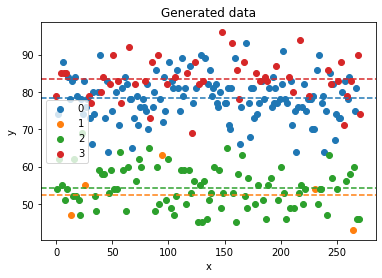

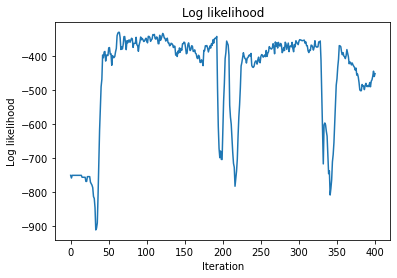

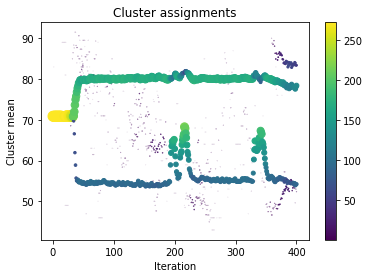

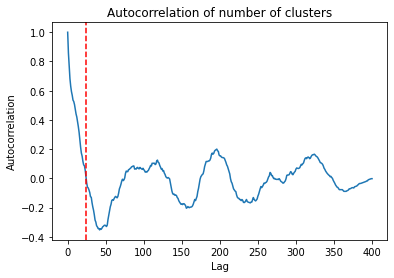

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.039229 seconds
Autocorrelation time: 40.78


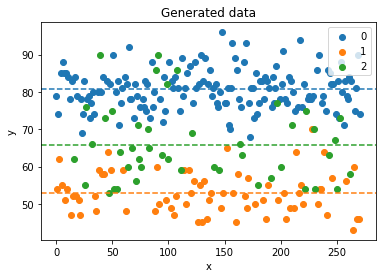

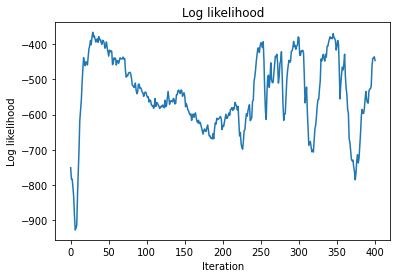

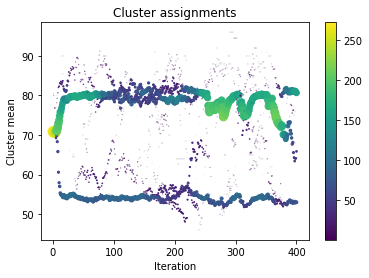

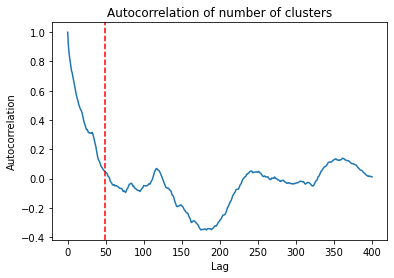

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.040456 seconds
Autocorrelation time: 36.21


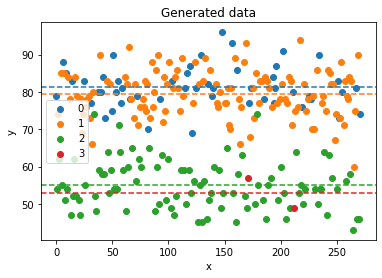

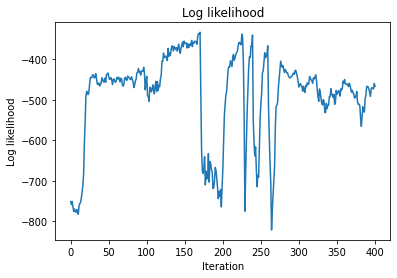

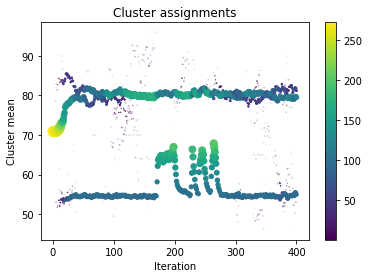

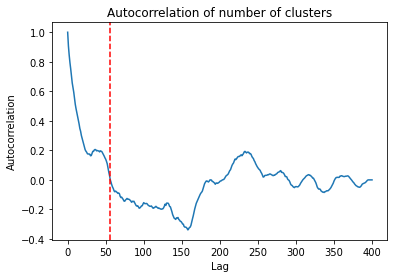

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.041100 seconds
Autocorrelation time: 80.10


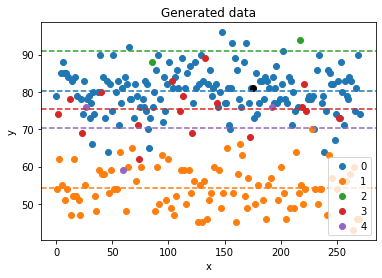

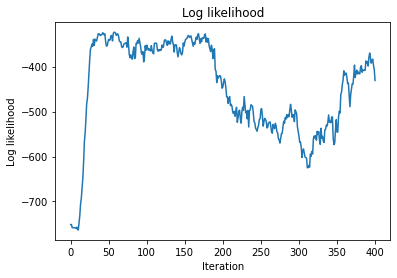

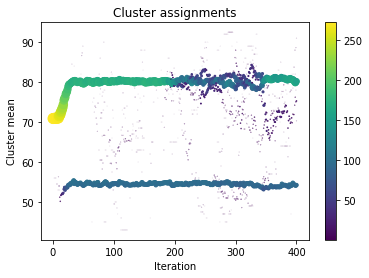

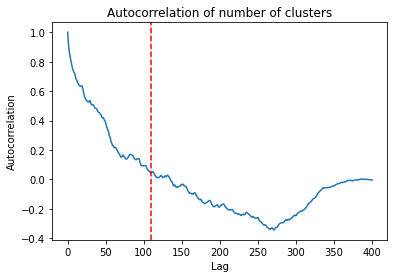

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.044627 seconds
Autocorrelation time: 29.83


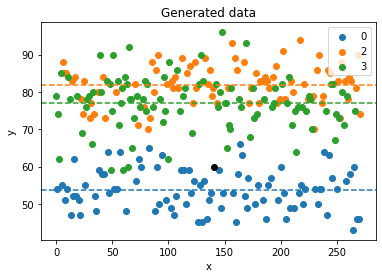

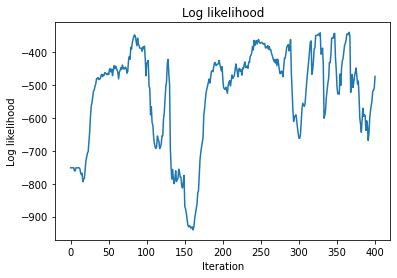

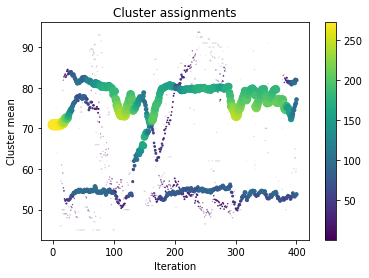

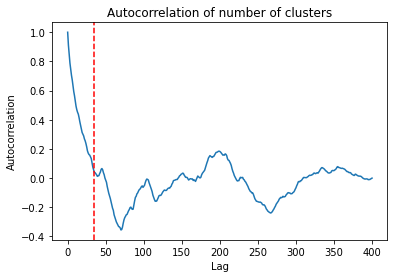

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.054405 seconds
Autocorrelation time: 12.68


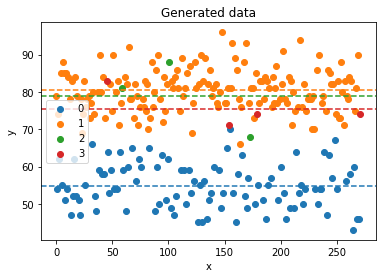

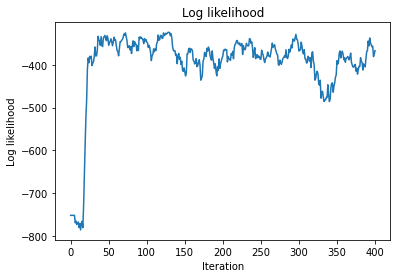

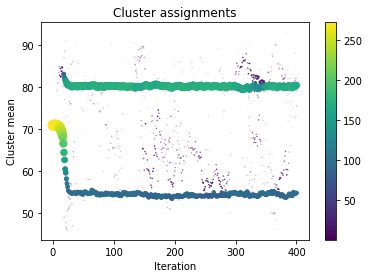

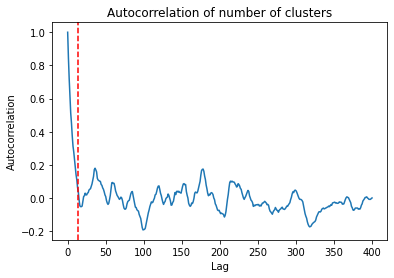

-----------------------------
alpha = 0.8


C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.053170 seconds
Autocorrelation time: 60.11


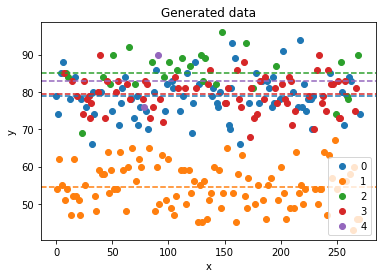

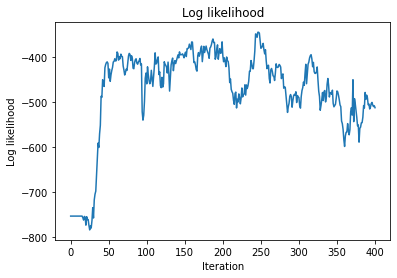

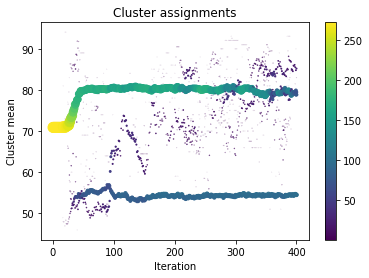

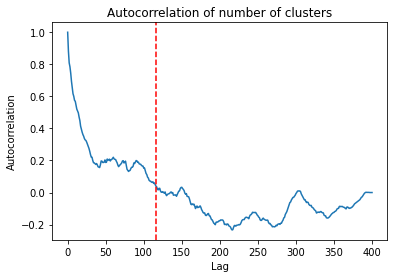

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.055941 seconds
Autocorrelation time: 16.11


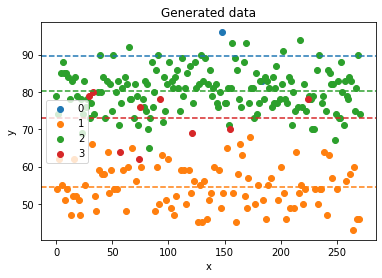

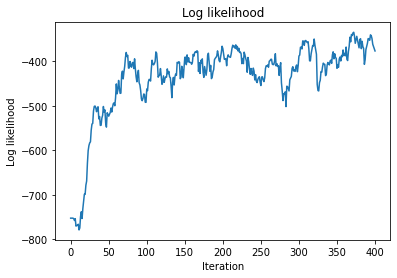

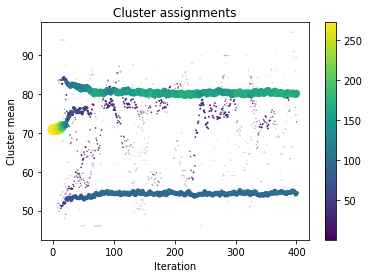

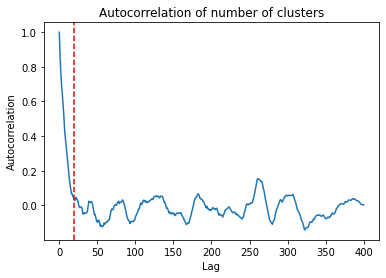

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.048587 seconds
Autocorrelation time: 21.49


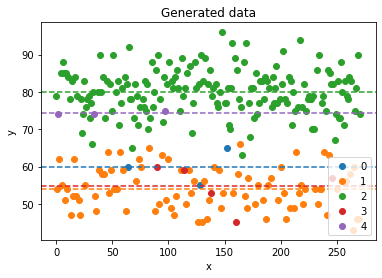

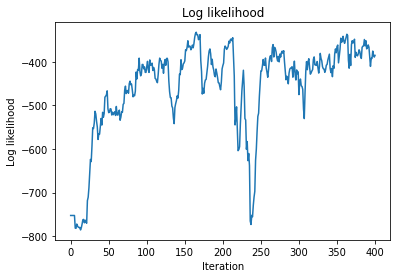

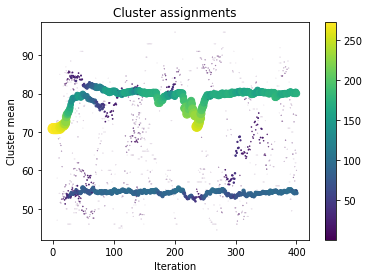

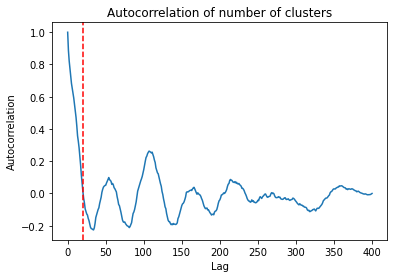

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.070991 seconds
Autocorrelation time: 19.97


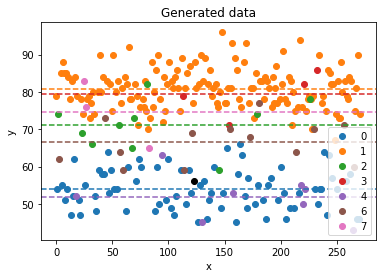

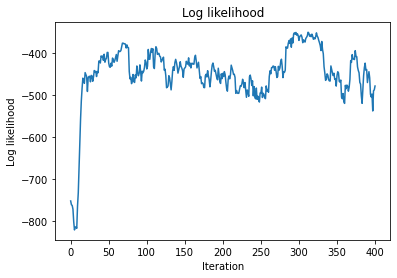

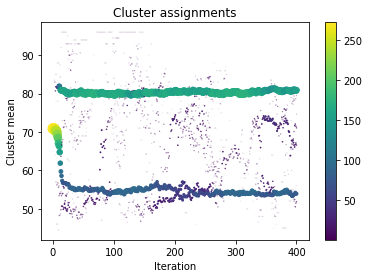

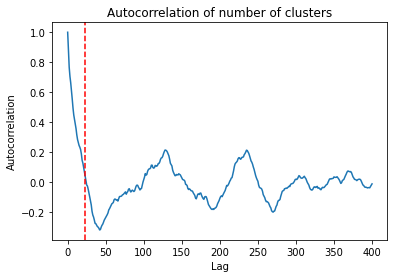

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.070464 seconds
Autocorrelation time: 52.75


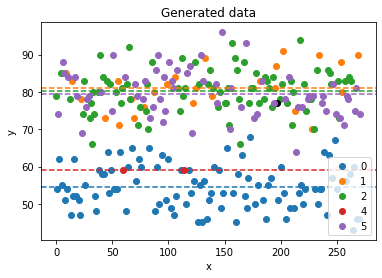

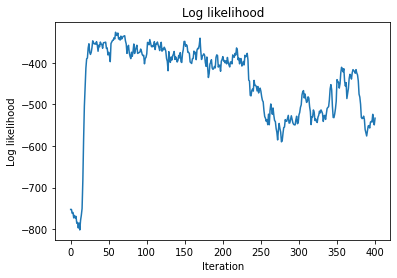

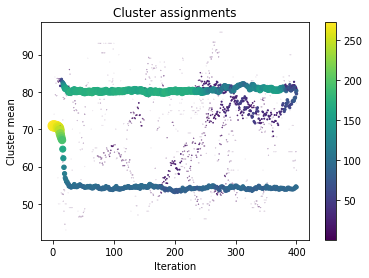

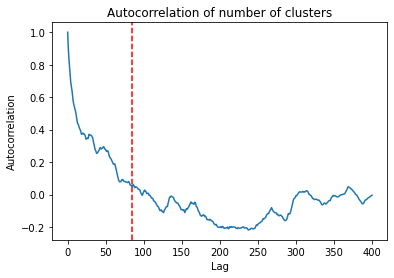

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.069147 seconds
Autocorrelation time: 15.61


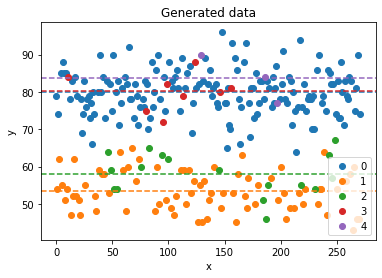

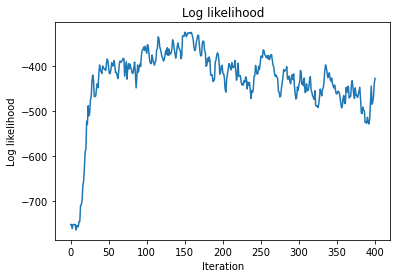

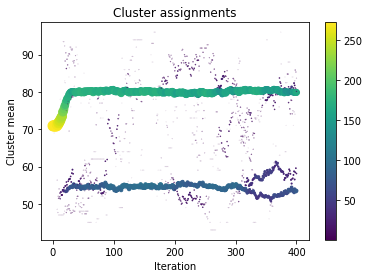

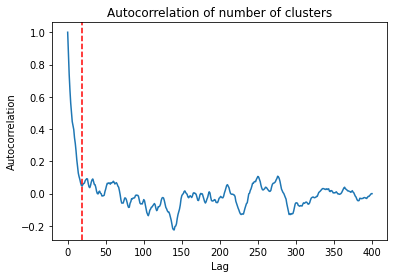

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.061268 seconds
Autocorrelation time: 25.95


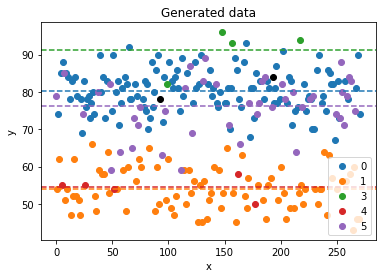

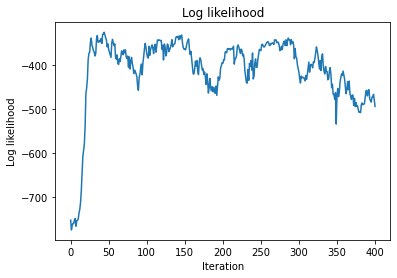

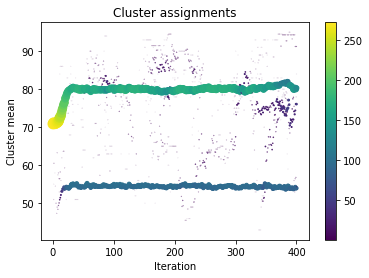

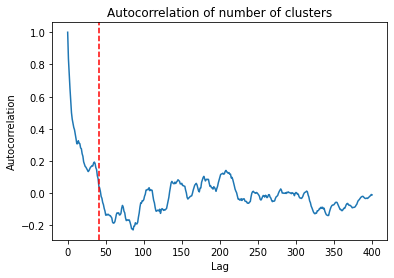

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.057950 seconds
Autocorrelation time: 22.60


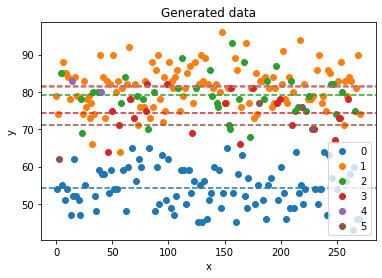

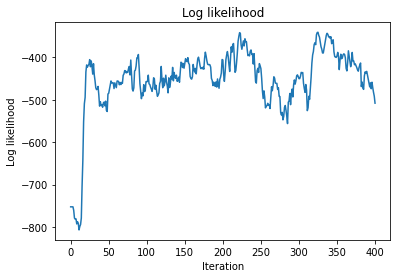

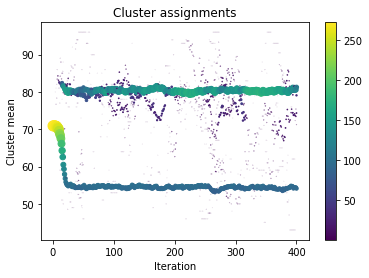

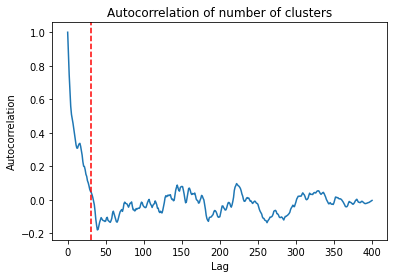

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.040042 seconds
Autocorrelation time: 22.06


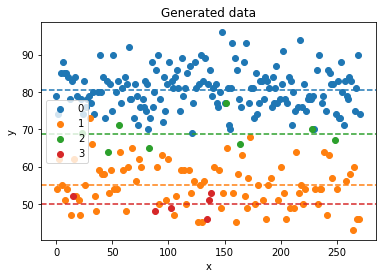

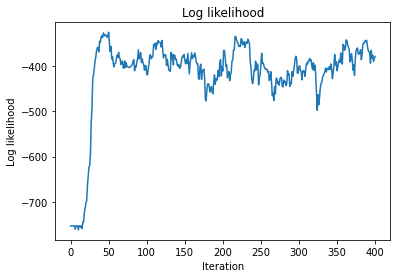

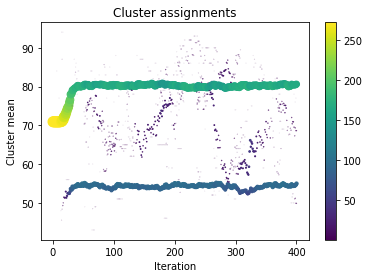

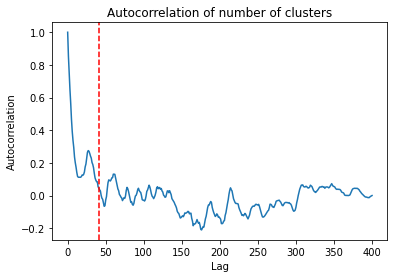

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.046677 seconds
Autocorrelation time: 28.26


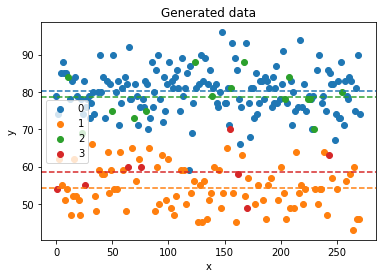

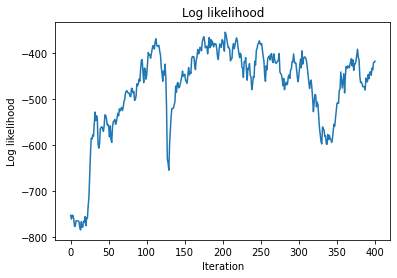

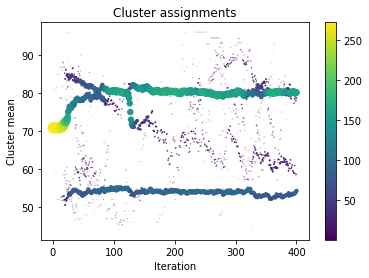

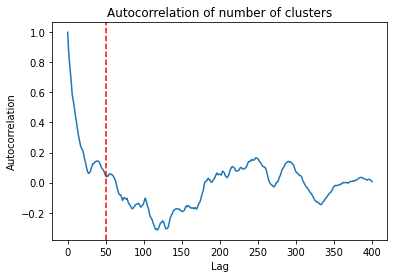

-----------------------------
alpha = 1


C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.040618 seconds
Autocorrelation time: 37.85


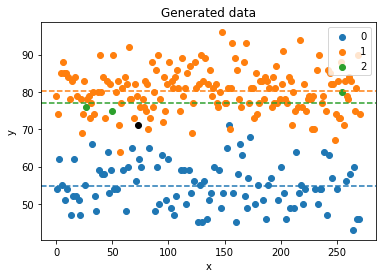

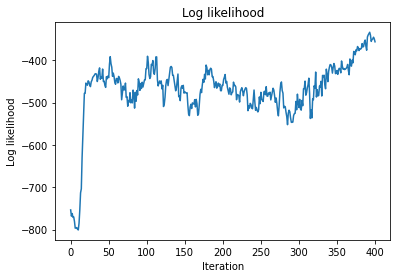

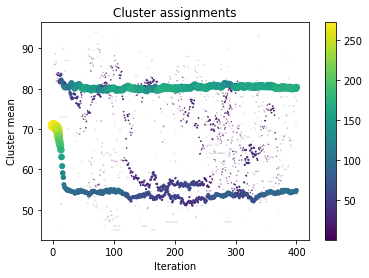

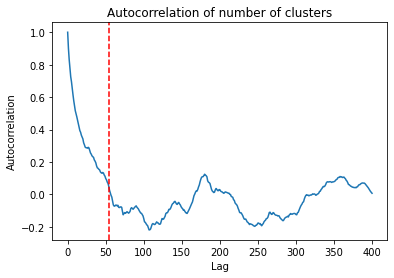

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.040504 seconds
Autocorrelation time: 22.80


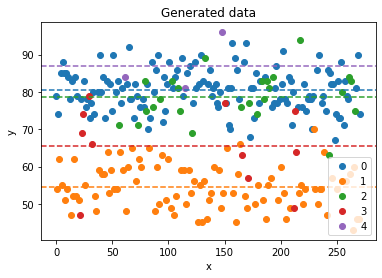

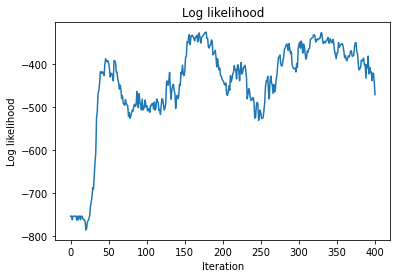

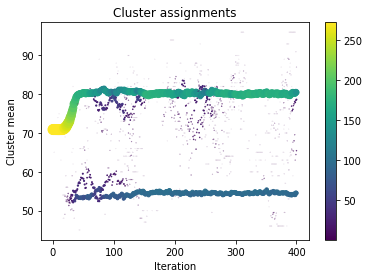

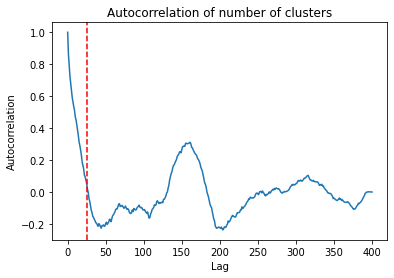

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.049472 seconds
Autocorrelation time: 13.42


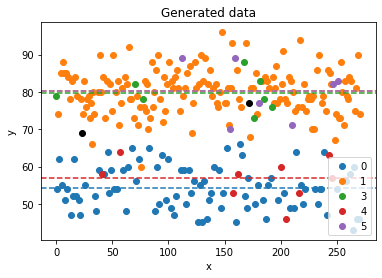

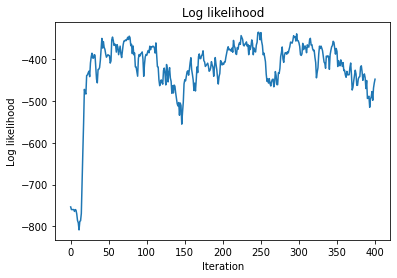

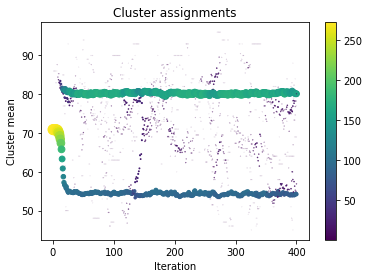

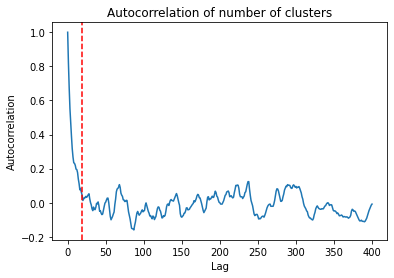

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.047861 seconds
Autocorrelation time: 19.22


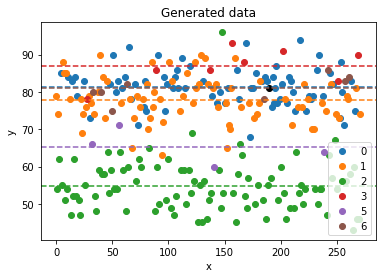

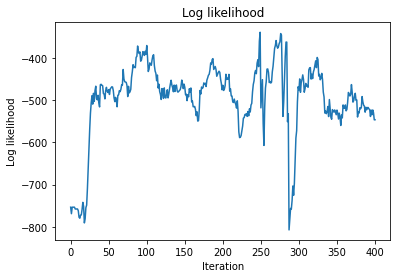

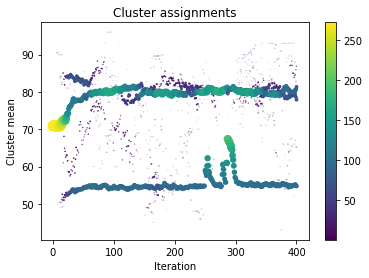

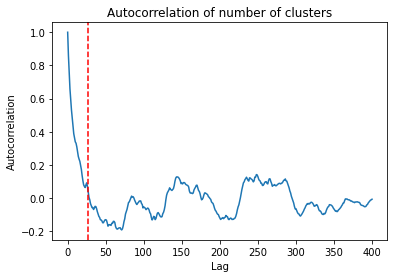

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.041980 seconds
Autocorrelation time: 15.01


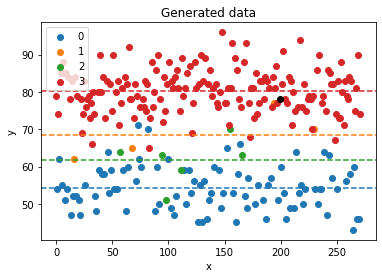

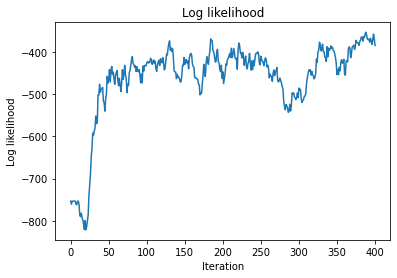

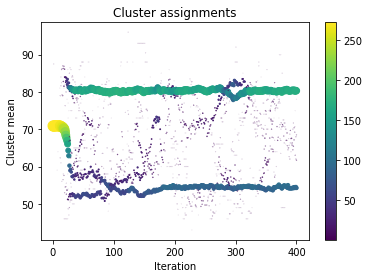

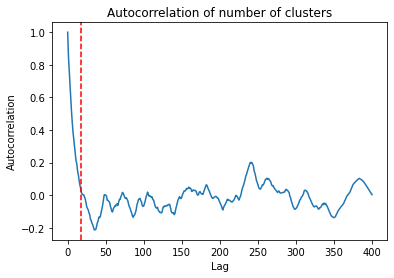

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.049602 seconds
Autocorrelation time: 42.42


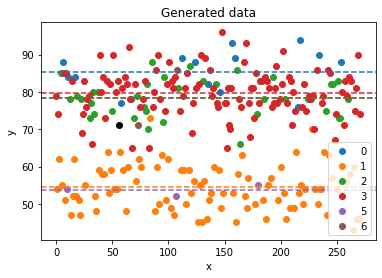

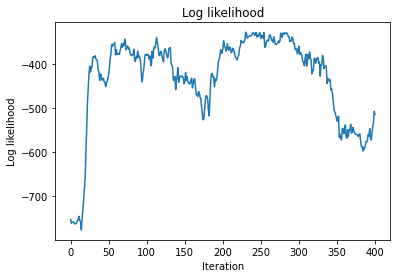

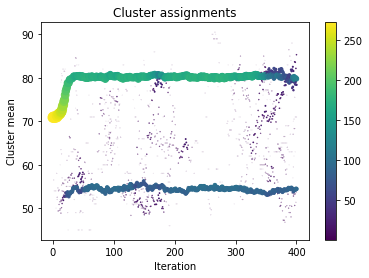

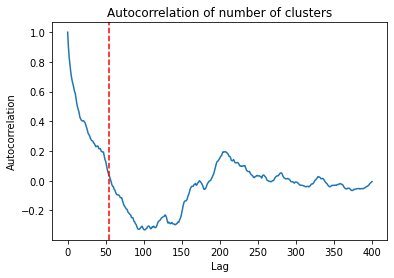

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.042464 seconds
Autocorrelation time: 78.98


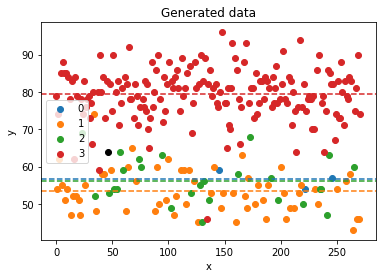

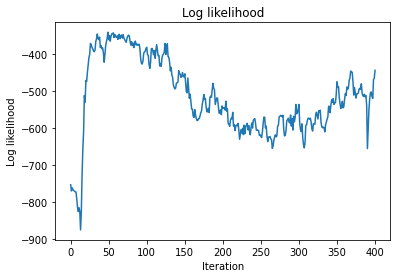

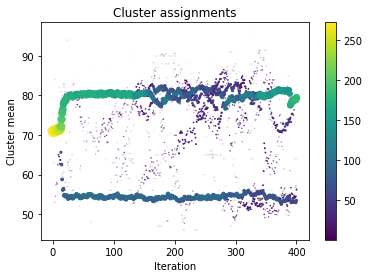

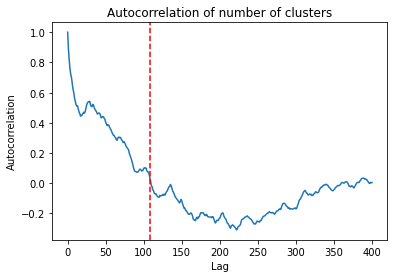

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.052359 seconds
Autocorrelation time: 82.06


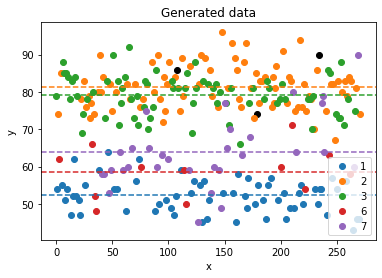

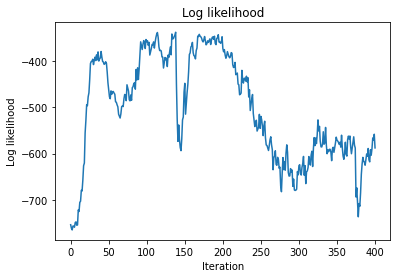

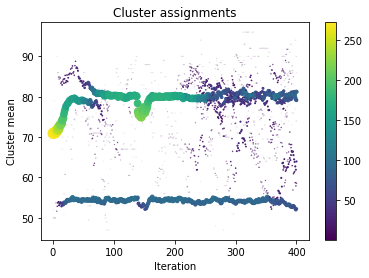

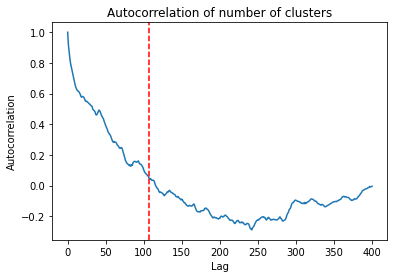

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.040197 seconds
Autocorrelation time: 17.09


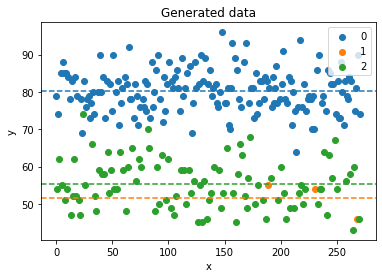

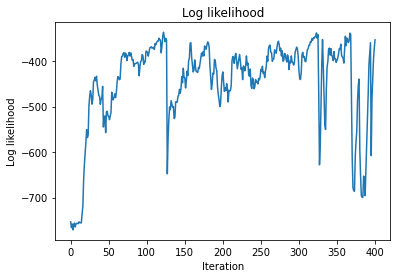

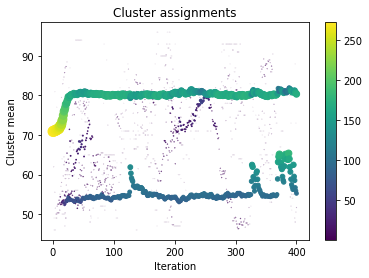

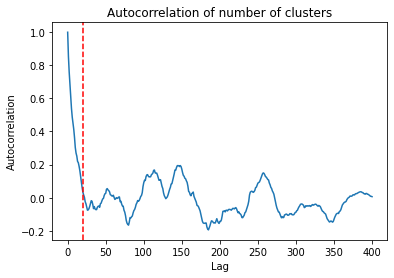

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.037512 seconds
Autocorrelation time: 14.16


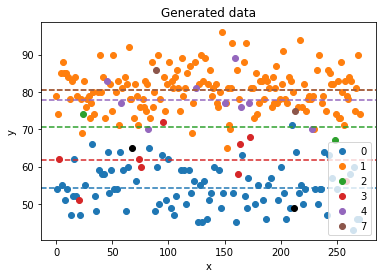

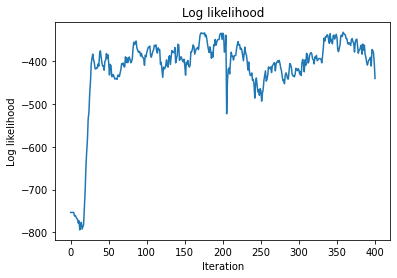

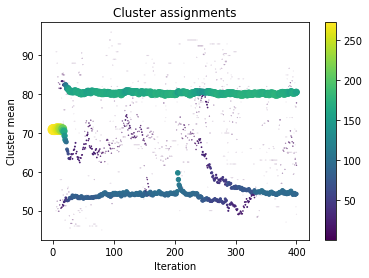

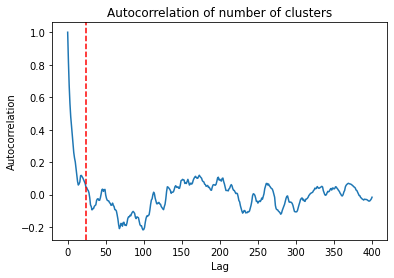

-----------------------------
alpha = 2


C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.045976 seconds
Autocorrelation time: 37.73


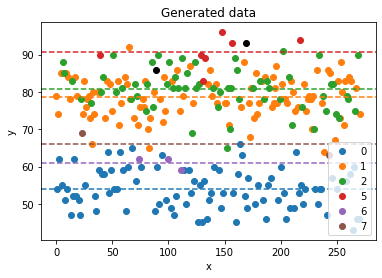

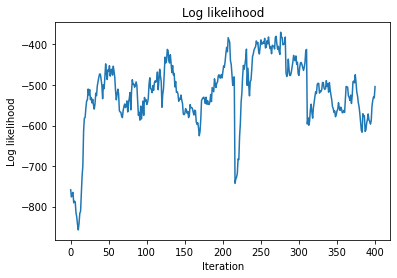

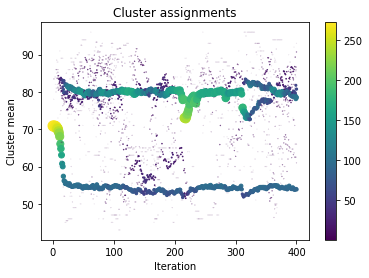

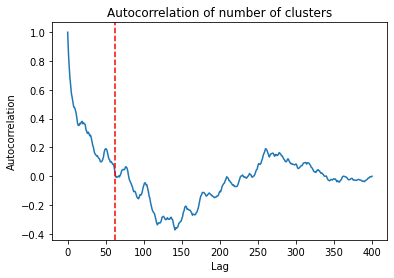

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.046101 seconds
Autocorrelation time: 18.75


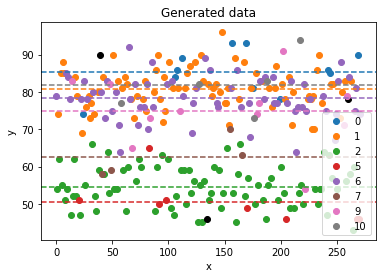

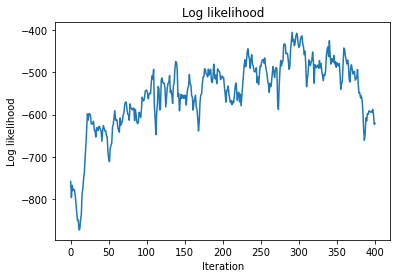

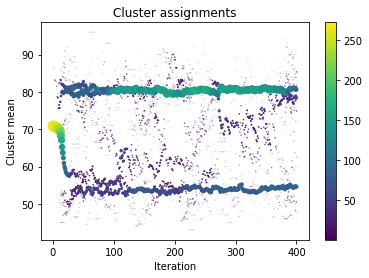

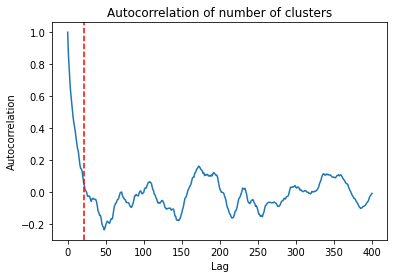

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.044254 seconds
Autocorrelation time: 30.89


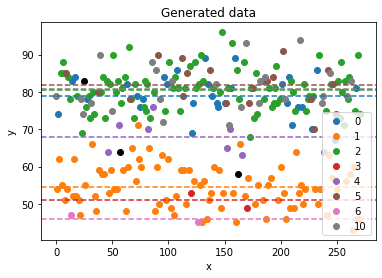

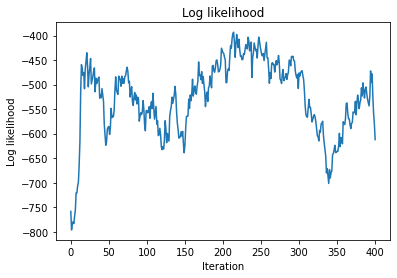

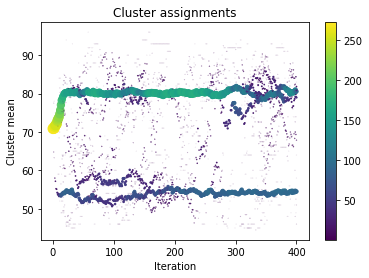

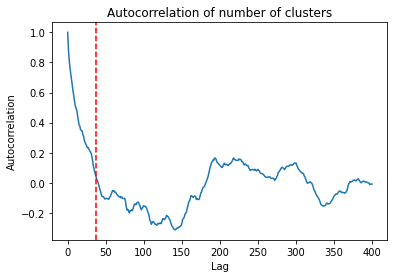

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.049867 seconds
Autocorrelation time: 51.96


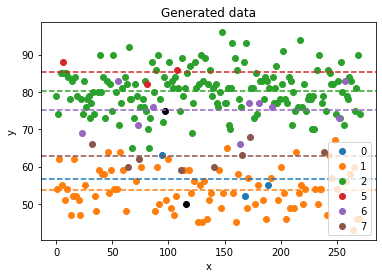

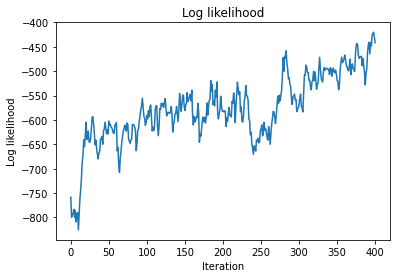

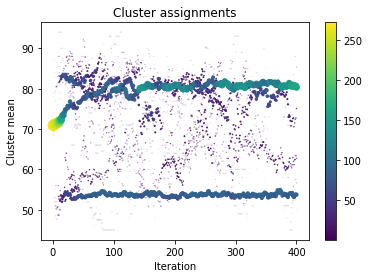

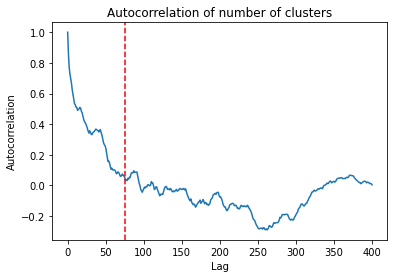

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.044475 seconds
Autocorrelation time: 14.50


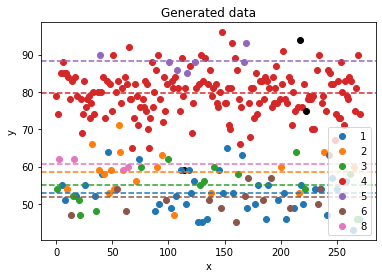

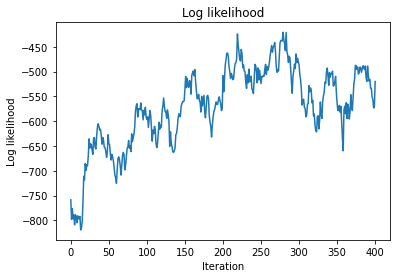

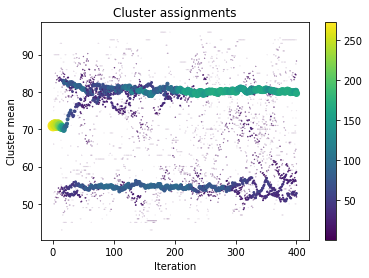

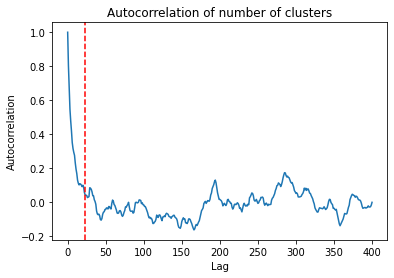

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.046128 seconds
Autocorrelation time: 34.00


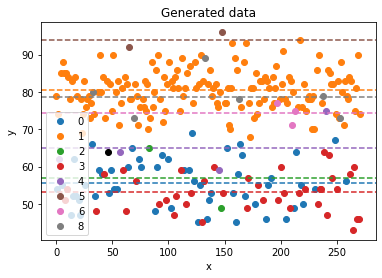

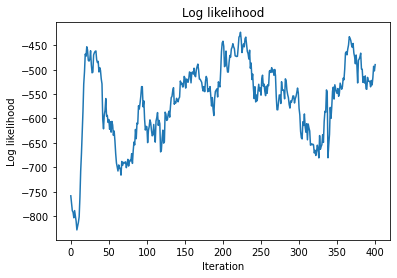

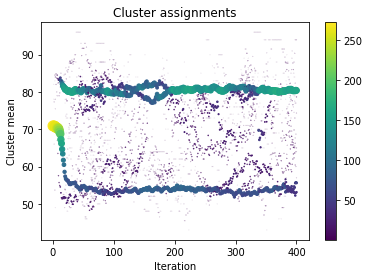

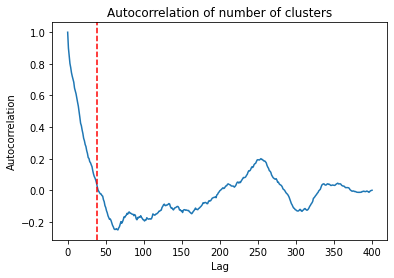

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.042396 seconds
Autocorrelation time: 21.19


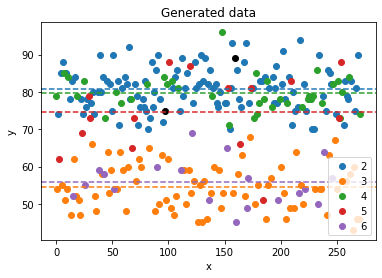

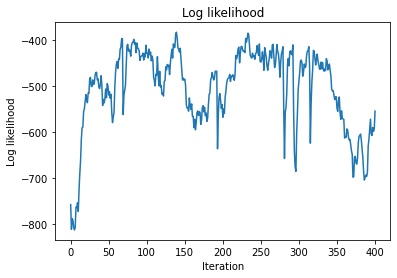

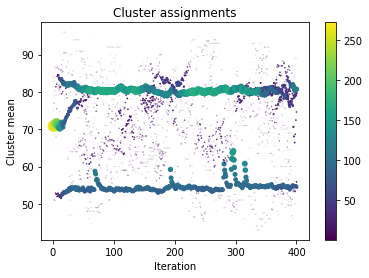

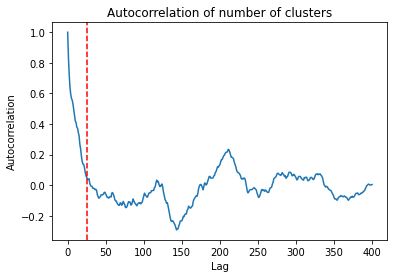

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.054684 seconds
Autocorrelation time: 31.53


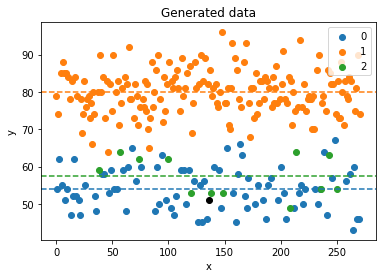

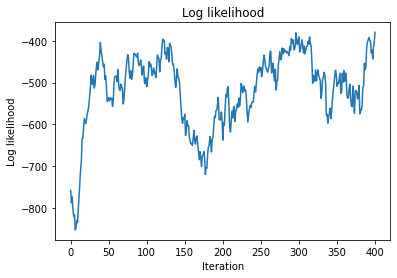

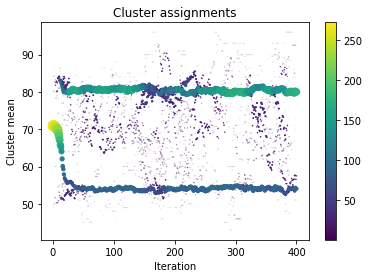

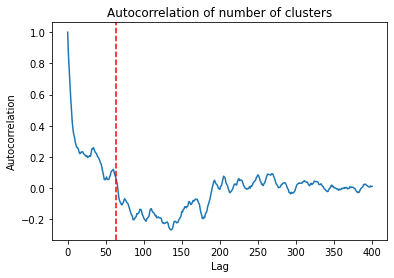

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.052380 seconds
Autocorrelation time: 44.49


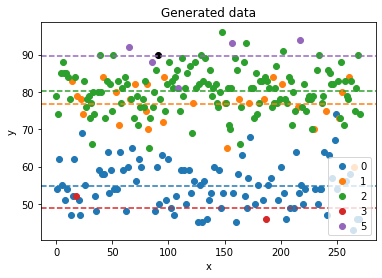

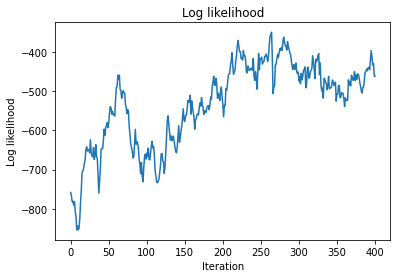

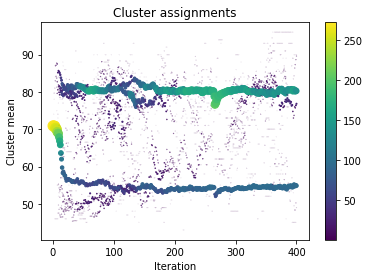

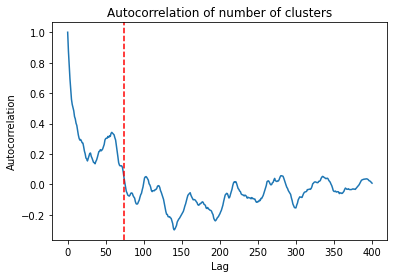

C:\Users\billo\AppData\Local\Temp\ipykernel_20520\1970859588.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_prob = min(1, lh_proposal / lh[ii])


Time per interation: 0.048200 seconds
Autocorrelation time: 11.60


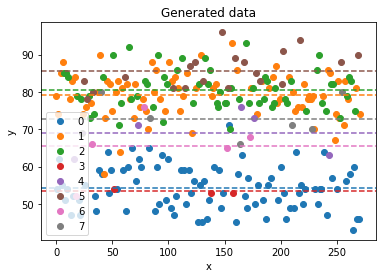

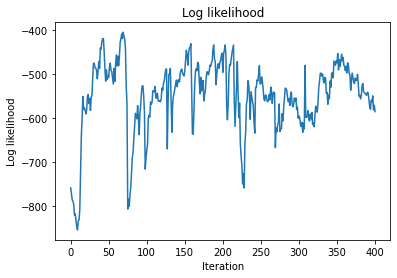

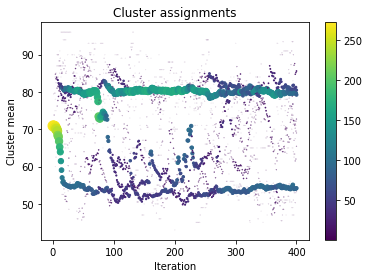

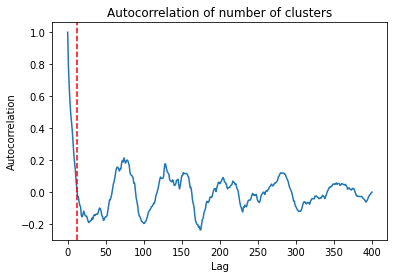

-----------------------------


In [50]:
for alpha in alphas:
    print(f"alpha = {alpha}")
    for _ in range(10):
        run_algorithm(lambda N, y: algorithm_5(N, y, alpha), 400, faithful_data)
    print("-----------------------------")